In [1]:
# --- PARAMETER FOR FILES ---
topic = 'costco_d' #topic for the file names example: 'costco'
RUN_SENTIMENT = False

# Preprocessing

## Total tweets

In [2]:
import pandas as pd
# Load & extract text
tweets = pd.read_csv(f'{topic}_corpus.csv', dtype={"Author ID": str, "Tweet ID": str})

# Drop column containing sentiment from each user's initial tweet
tweets = tweets.drop('Original User Sentiment', axis=1, errors='ignore')

# Remove empty tweets
tweets = tweets.dropna(subset=['Content'])

print("Before filtering, total tweets:", tweets.shape[0])
tweets.head()

Before filtering, total tweets: 18329


,Tweet ID,URL,Content,Author ID,Author Username,Author Blue Verified (T/F),Followers,Author Location,Likes,Views,Date
0,1979336580532965672,https://x.com/cuissekisser/status/197933658053...,@TripJaw you can be my costco bad bitch when y...,1752716081666387968,NaN,False,0,"Minneapolis, MN",1,22,"October 17, 2025 at 11:59 PM"
1,1979336435590402256,https://x.com/abdulrsyed_/status/1979336435590...,My greatest regret in life is seeing this at C...,1908244034692509697,NaN,False,0,NaN,0,8,"October 17, 2025 at 11:59 PM"
2,1979336376865927353,https://x.com/merdeka2670/status/1979336376865...,@xu96175836 カリフォルニアのCOSTCOに行くと、中国共産党幹部の情人らしき妊婦...,124460608,NaN,False,0,周防山口 築山館➡東京 大田区,0,241,"October 17, 2025 at 11:59 PM"
3,1979335869019623609,https://x.com/TheBondGuy2/status/1979335869019...,If anyone sees a line at @Costco of people try...,539294795,NaN,False,0,"Fort Lauderdale, FL",0,36,"October 17, 2025 at 11:57 PM"
4,1979335793341772138,https://x.com/TOONZ_JONES/status/1979335793341...,How costco got timbs for the low 😒🥴,102264984,NaN,False,0,Rant Ova,0,1541,"October 17, 2025 at 11:56 PM"


## Detect Bots and remove from corpus

In [3]:
import pandas as pd

# --- Basic Info ---
print("Before filtering, total tweets:", tweets.shape[0])

# --- Identify duplicates based on 'Content' ---
duplicate_mask = tweets.duplicated(subset='Content', keep='first')
duplicates_df = tweets[duplicate_mask].copy()        # suspected bots (duplicate content)
unique_tweets_df = tweets[~duplicate_mask].copy()    # non-duplicate tweets

# --- Summaries ---
num_duplicates = duplicates_df.shape[0]
num_bot_authors = duplicates_df['Author ID'].nunique()

print(f"Total duplicated tweets removed: {num_duplicates}")
print(f"Total unique bot authors detected: {num_bot_authors}")
print(f"Remaining unique tweets: {unique_tweets_df.shape[0]}")

# --- Optional inspection ---

# See which authors repeated themselves the most
bot_activity = (
    duplicates_df.groupby("Author ID")
    .agg(tweet_count=("Content", "count"), unique_texts=("Content", "nunique"))
    .sort_values("tweet_count", ascending=False)
)
print("\nTop 10 suspected bot accounts:")
print(bot_activity.head(10))

# --- Sort duplicates by 'Content' for easier inspection ---
duplicates_sorted = duplicates_df.sort_values(
    by=["Content", "Author ID"]
).reset_index(drop=True)

# --- Truncate long tweet text for display only ---
display_df = duplicates_sorted.copy()
max_len = 120  # <-- adjust this length as desired
display_df["Content"] = display_df["Content"].str.slice(0, max_len)
display_df.loc[display_df["Content"].str.len() >= max_len, "Content"] += "..."

# --- Show first few duplicate groups ---
print("\n=== Sorted duplicate tweets (by Content) ===")
print(
    display_df[["Author ID", "Content", "URL"]]
    .head(20)
    .to_string(index=False)
)

Before filtering, total tweets: 18329
Total duplicated tweets removed: 582
Total unique bot authors detected: 487
Remaining unique tweets: 17747

Top 10 suspected bot accounts:
                     tweet_count  unique_texts
Author ID                                     
341018943                      8             2
1336660338289340416            7             2
1833510386664148995            4             4
1662309277506371586            4             4
2279078148                     4             4
3010704366                     3             1
1923197602104999939            3             3
1222295660168220672            3             3
715097130206044160             3             3
707485297794101248             3             3

=== Sorted duplicate tweets (by Content) ===
          Author ID                                                                                                                     Content                                                     URL
1680644667627

## Detect language, filter to english

In [4]:
import re
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  # reproducible

# --- CLEANING (preserve Unicode letters; remove noise only) ---
def clean_for_lang(text: str) -> str:
    t = str(text)
    t = re.sub(r"http\S+|www\S+", " ", t)       # URLs
    t = re.sub(r"RT\s+@\w+:", " ", t)           # "RT @user:"
    t = re.sub(r"[@#]\w+", " ", t)              # @mentions / #hashtags
    t = re.sub(r"\s+", " ", t).strip()          # collapse whitespace
    return t

def safe_detect(text: str) -> str:
    t = clean_for_lang(text)
    # require some alphabetic signal (works for Unicode letters)
    if sum(ch.isalpha() for ch in t) < 10:
        return "unk"
    try:
        return detect(t)
    except:
        return "unk"

# --- DETECT on the SAME DF you plan to filter ---
unique_tweets_df["lang"] = unique_tweets_df["Content"].apply(safe_detect)

# --- FILTER ---
english_tweets = (
    unique_tweets_df[unique_tweets_df["lang"].eq("en")]
    .copy()
    .reset_index(drop=True)
)

print("After filtering, total tweets:", english_tweets.shape[0])

# (Optional) quick QC peek at what got removed
non_en_preview = (
    unique_tweets_df.loc[~unique_tweets_df["lang"].eq("en"), ["Content", "lang"]]
    .head(10)
    .to_string(index=False)
)
print("\nExamples removed as non-English:\n", non_en_preview)

After filtering, total tweets: 13941

Examples removed as non-English:
                                                                                                                                                                                                                                            Content lang
                                                                                                                                                                                           @xu96175836 カリフォルニアのCOSTCOに行くと、中国共産党幹部の情人らしき妊婦が沢山いますよ。🤣   ja
                                                                                                                                                                                                               ya les aviso a #Samsung y #costco ?   es
                                                                                                                                                                                        

## NLP: REGEX > Tokenize > POS > Lemmatization > Stop Words

In [5]:
# === Light, consistent cleaner (keeps hashtag text, contractions, digits) ===
import re
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import TweetTokenizer

URL_RE     = re.compile(r'https?://\S+|www\.\S+')
ORDINAL_RE = re.compile(r'(\d+)(st|nd|rd|th)\b', flags=re.I)
CAMEL_RE   = re.compile(r'(?<=[a-z])(?=[A-Z])')

def prepare_for_roberta(text: str) -> str:
    t = str(text)
    # CardiffNLP convention: normalize to @USER and HTTPURL
    t = re.sub(r'http\S+|www\.\S+', 'HTTPURL', t)
    t = re.sub(r'@\w+', '@USER', t)
    # IMPORTANT: keep hashtags as "#word" — the model learned that signal
    return t.strip()

# Preprocessing tailored for CardiffNLP sentiment models

def clean_for_nlp(text: str) -> str:
    t = str(text).lower()
    t = URL_RE.sub(" ", t)
    t = ORDINAL_RE.sub(r"\1", t)
    # remove @mentions
    t = re.sub(r'@\w+', ' ', t)
    # keep hashtag text (split CamelCase into words)
    def _strip_hash(m):
        w = m.group(1)
        if CAMEL_RE.search(w):
            w = CAMEL_RE.sub(" ", w)
        return " " + w + " "
    t = re.sub(r'#([A-Za-z0-9_]+)', _strip_hash, t)
    # remove RT token
    t = re.sub(r'\brt\b', ' ', t)
    # keep letters, digits, spaces, apostrophes
    t = re.sub(r"[^a-z0-9\s']", " ", t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

# -------- Build from english_tweets, but operate ONLY on `prep` thereafter --------
prep = english_tweets.copy().reset_index(drop=True)
prep["Content_clean"] = prep["Content"].apply(clean_for_nlp)

# === Tokenize → POS-aware lemmatize → remove stopwords (keep negations) ===
tok = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
wnl = WordNetLemmatizer()

def wn_pos(tb):
    if tb.startswith('J'): return wordnet.ADJ
    if tb.startswith('V'): return wordnet.VERB
    if tb.startswith('N'): return wordnet.NOUN
    if tb.startswith('R'): return wordnet.ADV
    return wordnet.NOUN

# Add stop words specific to the domain
NEG_KEEP = {"no","not","nor","n't","never","none"}
BASE_STOPS = set(stopwords.words("english"))
DOMAIN_STOPS = {
    # <- edit freely:
    "people","like","just","say","think","year","time",
    "government","country","party","today","tonight","tomorrow",
    "via","amp","…","gt"
}

stop_set = (BASE_STOPS - NEG_KEEP) | DOMAIN_STOPS

def preprocess_one(text: str):
    toks = tok.tokenize(text)
    # keep tokens that have at least one letter (drop pure punctuation/emoji)
    toks = [w for w in toks if any(ch.isalpha() for ch in w)]
    tagged = pos_tag(toks)
    lemmas = [wnl.lemmatize(w, wn_pos(tag)) for w, tag in tagged]
    nostop = [w for w in lemmas if w not in stop_set and len(w) > 1]
    return toks, lemmas, nostop

proc = prep["Content_clean"].apply(preprocess_one)
tokens, lemmas, nostop = zip(*proc)

# (Optional) enforce string dtype for IDs
if "Tweet ID" in prep.columns:
    prep["Tweet ID"] = prep["Tweet ID"].astype(str)

# Add text columns (these will appear at the end)
prep["text_for_sent"] = prep["Content"].fillna("").map(prepare_for_roberta)
prep["clean"]         = prep["Content_clean"]
prep["tokens"]        = list(tokens)
prep["lemmas"]        = list(lemmas)
prep["no_stop"]       = list(nostop)

# String forms for vectorizers
prep["clean_lemmas"]  = prep["lemmas"].apply(" ".join)   # lemmatized, stops kept (for QA)
prep["clean_nostop"]  = prep["no_stop"].apply(" ".join)  # lemmatized, stops removed (use for TF-IDF/LDA)

# Reorder so "original columns first, then text columns"
text_cols = ["text_for_sent", "clean", "tokens", "lemmas", "no_stop", "clean_lemmas", "clean_nostop"]
orig_cols = [c for c in prep.columns if c not in text_cols]
prep = prep[orig_cols + text_cols]

# Drop docs that became empty after cleaning (keeps all original cols aligned)
empty_mask = prep["clean_nostop"].str.len() == 0
print("Dropping empty docs:", int(empty_mask.sum()))
prep = prep[~empty_mask].reset_index(drop=True)

# Quick sanity checks
print("Docs after EN filter:", len(prep))
print("Empty after cleaning:", (prep['clean_nostop'].str.len()==0).sum())

# Optional: assert alignment between Content and text_for_sent - Tripwire to check if df manipulation misaligns indexes from original df
assert prep["text_for_sent"].equals(prep["Content"].fillna("").map(prepare_for_roberta)), \
       "text_for_sent no longer matches Content!"

Dropping empty docs: 5
Docs after EN filter: 13936
Empty after cleaning: 0


In [6]:
# No empty strings inside tokens
assert not any("" in lst for lst in prep["no_stop"])

# Joined string matches splitting back
test = prep["clean_nostop"].str.split().head(100)
ok = all(a == b for a, b in zip(test, prep["no_stop"].head(100)))
print("clean_nostop ≈ split(no_stop) on sample:", ok)


clean_nostop ≈ split(no_stop) on sample: True


# Sentiment Analysis by Document

## RoBERTa Transformer Model

In [7]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.notebook import tqdm

model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Build an index map from whatever the model exposes
id2label = model.config.id2label  # e.g., {0:'negative',1:'neutral',2:'positive'}
label_names = [id2label[i].lower() for i in range(model.config.num_labels)]
label_to_idx = {name: i for i, name in enumerate(label_names)}
pos_idx = label_to_idx.get("positive", None)
neg_idx = label_to_idx.get("negative", None)

texts = prep["text_for_sent"].fillna("").tolist()
assert len(texts) == len(prep), "Length mismatch: texts vs prep"

@torch.inference_mode()
def roberta_predict(texts, batch_size=32, max_length=280):
    all_probs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Scoring tweets"):
        batch = texts[i:i+batch_size]
        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        enc = {k: v.to(device) for k, v in enc.items()}
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()  # shape (B, num_labels)
        all_probs.append(probs)
    return np.vstack(all_probs) if all_probs else np.zeros((0, model.config.num_labels))

# --- Toggle run at the top here ---

if RUN_SENTIMENT:
    probs = roberta_predict(texts, batch_size=32, max_length=280)
    assert probs.shape[0] == len(prep), "Probabilities rows do not match prep rows!"

    # Probability columns with explicit names, e.g., rob_prob_negative/neutral/positive
    prob_df = pd.DataFrame(probs, columns=[f"rob_prob_{n}" for n in label_names])
    
    # Concat side-by-side (prep already has clean RangeIndex)
    prep = pd.concat([prep, prob_df], axis=1)

    # Discrete label via argmax over the dynamic columns
    prep["rob_label"] = prob_df.idxmax(axis=1).str.replace("rob_prob_", "", regex=False)

    # Polarity score (pos - neg) if available
    if pos_idx is not None and neg_idx is not None:
        prep["rob_score"] = probs[:, pos_idx] - probs[:, neg_idx]
    else:
        prep["rob_score"] = np.nan  # model didn't expose both labels as expected

    # Save a concise per-doc CSV (includes the exact text fed to the model)
    prep.to_parquet(f"{topic}_scores.parquet", index=False)
# Quick peek (head still runs even if SA is skipped)
prep.head(1)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,Tweet ID,URL,Content,Author ID,Author Username,Author Blue Verified (T/F),Followers,Author Location,Likes,Views,Date,lang,Content_clean,text_for_sent,clean,tokens,lemmas,no_stop,clean_lemmas,clean_nostop
0,1979336580532965672,https://x.com/cuissekisser/status/197933658053...,@TripJaw you can be my costco bad bitch when y...,1752716081666387968,NaN,False,0,"Minneapolis, MN",1,22,"October 17, 2025 at 11:59 PM",en,you can be my costco bad bitch when you come v...,@USER you can be my costco bad bitch when you ...,you can be my costco bad bitch when you come v...,"[you, can, be, my, costco, bad, bitch, when, y...","[you, can, be, my, costco, bad, bitch, when, y...","[costco, bad, bitch, come, visit, comically, l...",you can be my costco bad bitch when you come v...,costco bad bitch come visit comically large sa...


## Read results from csv, merge to df

In [8]:
import pandas as pd
from pathlib import Path

path = Path(f"{topic}_scores.parquet")
assert path.exists(), f"Missing file: {path}"

prep = pd.read_parquet(path)

# Basic schema checks (adjust if you renamed anything)
required_cols = {
    "Tweet ID", "URL", "Content", "text_for_sent",
    "rob_label", "rob_prob_negative", "rob_prob_neutral", "rob_prob_positive"
}
missing = required_cols - set(prep.columns)
assert not missing, f"Expected columns missing from parquet: {sorted(missing)}"

# Type hygiene
if "Tweet ID" in prep.columns:
    prep["Tweet ID"] = prep["Tweet ID"].astype(str)

# Quick sanity prints
print("Rows:", len(prep))
print("Label counts:\n", prep["rob_label"].value_counts(dropna=False))

prep.head(1)

Rows: 13936
Label counts:
 rob_label
neutral     6853
negative    3666
positive    3417
Name: count, dtype: int64


,Tweet ID,URL,Content,Author ID,Author Username,Author Blue Verified (T/F),Followers,Author Location,Likes,Views,...,tokens,lemmas,no_stop,clean_lemmas,clean_nostop,rob_prob_negative,rob_prob_neutral,rob_prob_positive,rob_label,rob_score
0,1979336580532965672,https://x.com/cuissekisser/status/197933658053...,@TripJaw you can be my costco bad bitch when y...,1752716081666387968,NaN,False,0,"Minneapolis, MN",1,22,...,"[you, can, be, my, costco, bad, bitch, when, y...","[you, can, be, my, costco, bad, bitch, when, y...","[costco, bad, bitch, come, visit, comically, l...",you can be my costco bad bitch when you come v...,costco bad bitch come visit comically large sa...,0.477086,0.398851,0.124063,negative,-0.353022


## Distribution By Sentiment

In [9]:
import matplotlib.pyplot as plt
plt.style.use("default")  # keep if you want Matplotlib defaults

# Get cycle safely
cycle = plt.rcParams.get("axes.prop_cycle", None)
colors = cycle.by_key()["color"] if cycle is not None else []

# Fallbacks if cycle is short/empty
if len(colors) < 3:
    # Matplotlib default Tableau 10 fallbacks
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

print(colors)  # list of hex codes

# Freeze named colors for later plots
neg_color = colors[0]
pos_color = colors[1]
neu_color = colors[2]


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


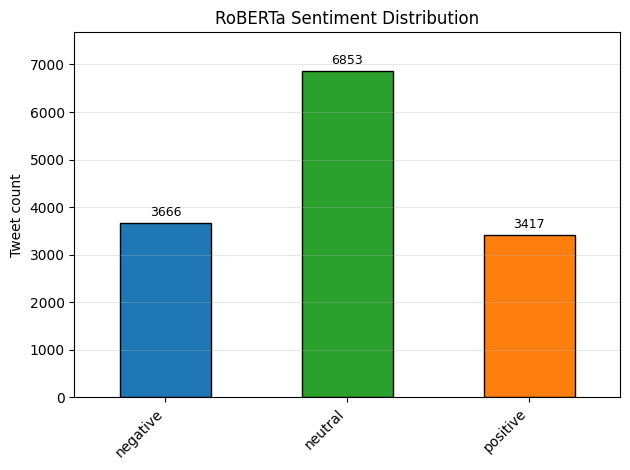

In [10]:
import matplotlib.pyplot as plt

order = ["negative", "neutral", "positive"]
counts = prep["rob_label"].value_counts().reindex(order, fill_value=0)

neg_c = globals().get("neg_color", "#d62728")
neu_c = globals().get("neu_color", "#7f7f7f")
pos_c = globals().get("pos_color", "#2ca02c")
colors = [neg_c, neu_c, pos_c]

ax = counts.plot(kind="bar", color=colors, edgecolor="black")
ax.set_title("RoBERTa Sentiment Distribution")
ax.set_ylabel("Tweet count")
ax.set_xlabel("")
ax.grid(axis="y", alpha=0.3)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# 1) Add headroom so labels don't collide
ymax = int(counts.max())
ax.set_ylim(0, ymax * 1.12 + (1 if ymax == 0 else 0))  # ~12% padding

# 2) Add labels with padding; fallback if bar_label isn't available
if hasattr(ax, "bar_label"):
    ax.bar_label(ax.containers[0], labels=[f"{v}" for v in counts], padding=3, fontsize=9)
else:
    for p, val in zip(ax.patches, counts):
        ax.annotate(f"{int(val)}",
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha="center", va="bottom", fontsize=9,
                    xytext=(0, 3), textcoords="offset points",
                    clip_on=False)

plt.tight_layout()
plt.show()


# EDA - Token Frequency

## Distribution of tweets / user

  rob_label  n_users  min  max      mean
0  negative     3398    1   14  1.078870
1   neutral     5967    1  101  1.148483
2  positive     3039    1   27  1.124383


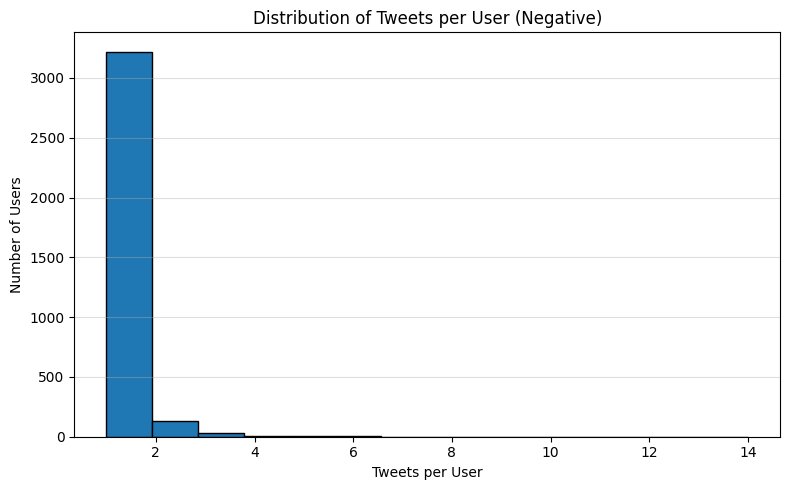

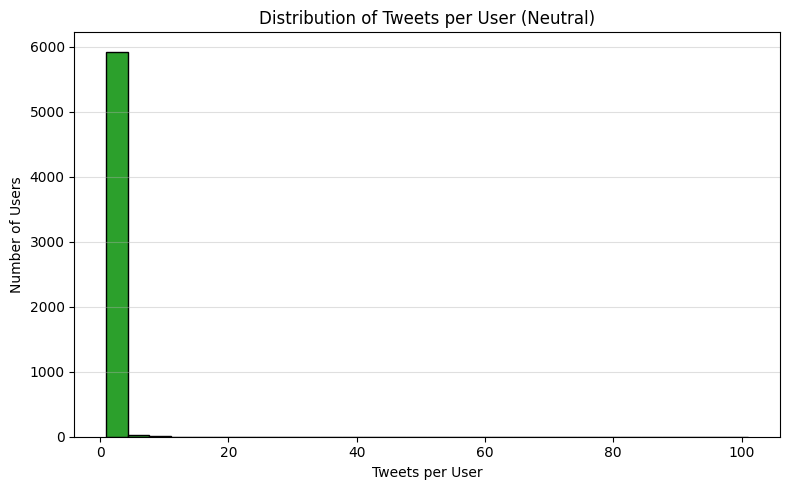

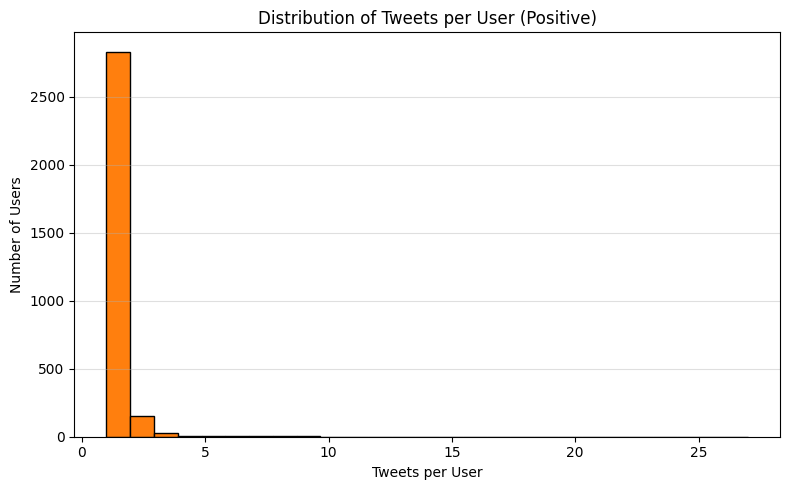

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure required cols exist
assert {"rob_label", "Author ID"} <= set(prep.columns), "Missing columns in prep"

# Drop rows with missing Author ID (can't group by NaN reliably)
safe = prep.dropna(subset=["Author ID"]).copy()

# Count tweets per Author ID within each sentiment
tweet_counts = (
    safe.groupby(["rob_label", "Author ID"], dropna=False)
        .size()
        .reset_index(name="tweet_count")
)

# Summarize per sentiment
summary = (
    tweet_counts.groupby("rob_label")["tweet_count"]
        .agg(["count", "min", "max", "mean"])
        .rename(columns={"count": "n_users"})
        .reset_index()
)
print(summary)

# Colors consistent with your palette (fallbacks if not defined)
neg_c = globals().get("neg_color", "#d62728")
neu_c = globals().get("neu_color", "#7f7f7f")
pos_c = globals().get("pos_color", "#2ca02c")
cmap = {"negative": neg_c, "neutral": neu_c, "positive": pos_c}

# Plot histograms, one per sentiment (skip gracefully if none)
for sentiment in ["negative", "neutral", "positive"]:
    subset = tweet_counts.loc[tweet_counts["rob_label"] == sentiment, "tweet_count"].to_numpy()

    if subset.size == 0:
        print(f"(No users for sentiment={sentiment}, skipping histogram.)")
        continue

    # Choose a sensible bin count based on data range
    bins = min(30, int(np.ptp(subset)) + 1 if subset.size > 1 else 5)

    plt.figure(figsize=(8, 5))
    plt.hist(subset, bins=bins, edgecolor="black", color=cmap[sentiment])
    plt.title(f"Distribution of Tweets per User ({sentiment.title()})")
    plt.xlabel("Tweets per User")
    plt.ylabel("Number of Users")
    plt.grid(axis="y", alpha=0.4)
    plt.tight_layout()
    plt.show()


## Distribution of words / tweet

  rob_label  count  min  max       mean  median
0  negative   3666    1  193  14.007365    12.0
1   neutral   6853    1  391  10.997665     8.0
2  positive   3417    1  183  12.364062    10.0


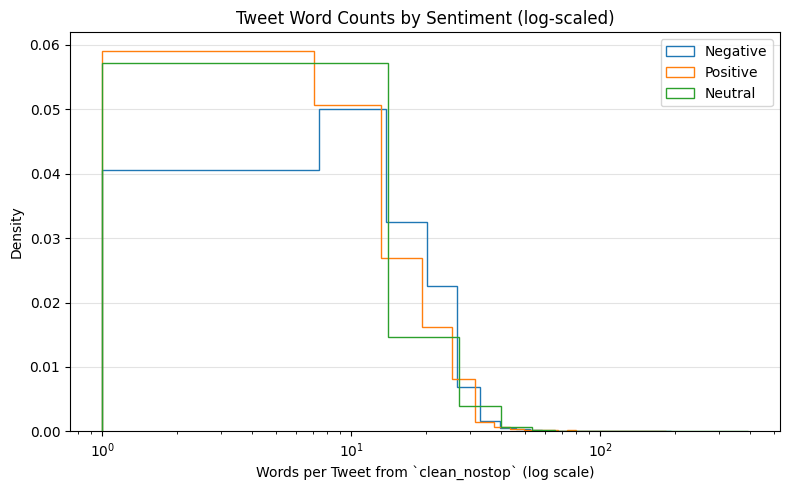

In [12]:
# === Word-count distribution from an existing text column (no mutation) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Pick the text column you want to count words from
#    (override TEXT_COL manually if you prefer a specific one)
TEXT_COL = next(c for c in ["clean_nostop","clean_lemmas","clean","text","original"] if c in prep.columns)

# 2) Compute word counts as a temporary Series (no assignment to prep)
def _word_count_series(series: pd.Series) -> pd.Series:
    # treat NaN or non-strings safely; split on whitespace
    return series.astype(str).str.split().map(len).astype(int)

wc = _word_count_series(prep[TEXT_COL])

# 3) Slice by sentiment (again, no mutation)
neg = wc[prep["rob_label"].eq("negative")].to_numpy()
neu = wc[prep["rob_label"].eq("neutral")].to_numpy()
pos = wc[prep["rob_label"].eq("positive")].to_numpy()

# Drop zeros to avoid log(0)
neg_nz = neg[neg > 0]
neu_nz = neu[neu > 0]
pos_nz = pos[pos > 0]

# 4) Quick summary table (optional)
summary_wc = (
    pd.DataFrame({"rob_label": prep["rob_label"], "wc": wc})
      .groupby("rob_label", dropna=False)["wc"]
      .agg(["count","min","max","mean","median"])
      .reset_index()
)
print(summary_wc)

# 5) Plot (colors fall back if your theme vars aren't set)
neg_color = globals().get("neg_color", "#d62728")
neu_color = globals().get("neu_color", "#7f7f7f")
pos_color = globals().get("pos_color", "#2ca02c")

plt.figure(figsize=(8,5))
if neg_nz.size: plt.hist(neg_nz, bins=30, density=True, histtype="step", label="Negative", color=neg_color)
if pos_nz.size: plt.hist(pos_nz, bins=30, density=True, histtype="step", label="Positive", color=pos_color)
if neu_nz.size: plt.hist(neu_nz, bins=30, density=True, histtype="step", label="Neutral",  color=neu_color)

plt.xscale("log")
plt.xlabel(f"Words per Tweet from `{TEXT_COL}` (log scale)")
plt.ylabel("Density")
plt.title("Tweet Word Counts by Sentiment (log-scaled)")
plt.legend()
plt.grid(axis="y", alpha=0.35)
plt.tight_layout()
plt.show()


## Distribution of characters / tweet

  rob_label  count  min   max       mean  median
0  negative   3666    4  1360  86.418712    71.0
1   neutral   6853    3  2763  68.332409    47.0
2  positive   3417    5  1276  76.912204    60.0


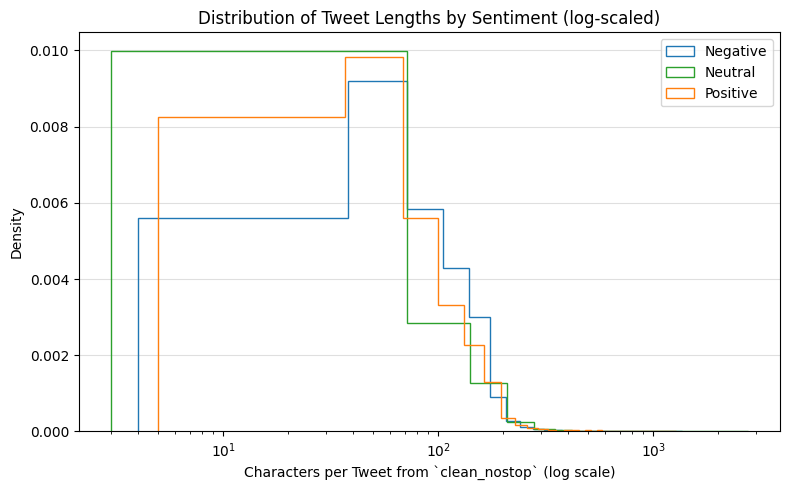

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ----- colors (fallbacks if your theme vars aren't set) -----
color_map = {
    "negative": globals().get("neg_color", "#d62728"),
    "neutral":  globals().get("neu_color", "#7f7f7f"),
    "positive": globals().get("pos_color", "#2ca02c"),
}

# ----- choose text column & compute char counts (no mutation) -----
TEXT_COL = next(c for c in ["clean_nostop","clean_lemmas","clean","text","original"] if c in prep.columns)
char_count = prep[TEXT_COL].fillna("").astype(str).str.len()

# Summary per sentiment
summary_cc = (
    pd.DataFrame({"rob_label": prep["rob_label"], "char_count": char_count})
      .groupby("rob_label", dropna=False)["char_count"]
      .agg(["count","min","max","mean","median"])
      .reset_index()
)
print(summary_cc)

# Plot
plt.figure(figsize=(8, 5))
for s in ["negative", "neutral", "positive"]:
    subset = char_count[prep["rob_label"].eq(s)].to_numpy()
    subset = subset[subset > 0]  # avoid log(0)
    if subset.size == 0:
        continue
    bins = int(np.clip(np.sqrt(subset.size), 10, 40))
    plt.hist(subset, bins=bins, density=True, histtype="step",
             color=color_map[s], label=s.title())

plt.xscale("log")
plt.xlabel(f"Characters per Tweet from `{TEXT_COL}` (log scale)")
plt.ylabel("Density")
plt.title("Distribution of Tweet Lengths by Sentiment (log-scaled)")
plt.legend()
plt.grid(axis="y", alpha=0.4)
plt.tight_layout()
plt.show()


## Most Frequent Tokens - Split

In [14]:
# --- quick peek at `no_stop` before/after and basic diagnostics ---

import pandas as pd, numpy as np, re, ast
from collections import Counter
from itertools import chain

def _ensure_tokens(x):
    if isinstance(x, (list, tuple)):
        return [str(t).strip() for t in x if isinstance(t, (str, bytes)) and str(t).strip()]
    if x is None or (isinstance(x, float) and pd.isna(x)): return []
    s = str(x).strip()
    if not s or s.lower() == "nan": return []
    if len(s) >= 2 and s[0] == "[" and s[-1] == "]":
        try:
            y = ast.literal_eval(s)
            if isinstance(y, (list, tuple)):
                return [str(t).strip() for t in y if isinstance(t, (str, bytes)) and str(t).strip()]
        except Exception: pass
    s = re.sub(r"[\"\'\[\]]", " ", s)
    parts = re.split(r"[,\s]+", s)
    return [p for p in parts if p]

# 1) type mix + a few raw samples
print("type counts in no_stop:")
print(prep["no_stop"].apply(lambda x: type(x).__name__).value_counts().head(10), "\n")

print("raw samples:")
print(prep["no_stop"].head(10).to_list(), "\n")

# 2) side-by-side preview (random 20 rows)
np.random.seed(0)
idx = np.random.choice(prep.index, size=min(20, len(prep)), replace=False)
preview = (
    prep.loc[idx, ["rob_label","no_stop"]]
        .assign(parsed=lambda d: d["no_stop"].apply(_ensure_tokens),
                parsed_join=lambda d: d["no_stop"].apply(_ensure_tokens).apply(lambda z: " | ".join(z)))
)
print(preview.to_string(index=True), "\n")

# 3) rows where parser yields 1 monster token (likely concatenation issue)
problem_rows = (
    prep.assign(raw_str=lambda d: d["no_stop"].astype(str))
        .assign(tokens=lambda d: d["no_stop"].apply(_ensure_tokens))
)
mask_prob = problem_rows["tokens"].apply(len).eq(1) & problem_rows["raw_str"].str.len().ge(25)
print("suspected glued-token rows (showing 15):")
print(problem_rows.loc[mask_prob, ["rob_label","no_stop","tokens"]].head(15).to_string(index=True), "\n")

# 4) longest tokens after parsing (top 25)
all_tokens = list(chain.from_iterable(problem_rows["tokens"]))
longest = sorted(all_tokens, key=len, reverse=True)[:25]
print("longest tokens after parsing:")
for w in longest:
    print(len(w), w)

# 5) frequency of tokens with no separators originally (only letters/digits, length>=20)
def no_seps(s): 
    s = re.sub(r"\W+", "", str(s))
    return len(s) >= 20
print("\nexamples of raw with no separators:")
print(problem_rows.loc[problem_rows["raw_str"].apply(no_seps), ["no_stop"]].head(15).to_string(index=True))

type counts in no_stop:
no_stop
ndarray    13936
Name: count, dtype: int64 

raw samples:
[array(['costco', 'bad', 'bitch', 'come', 'visit', 'comically', 'large',
       'sack', 'full', 'rotisserie', 'chicken'], dtype=object), array(['great', 'regret', 'life', 'see', 'costco', 'not', 'buy',
       'november'], dtype=object), array(['anyone', 'see', 'line', 'try', 'buy', 'gold', 'bar', 'let',
       'know', 'sell', 'stock', 'thank'], dtype=object), array(['costco', 'get', 'timbs', 'low'], dtype=object), array(['send', 'home', 'look', 'turn', 'firework', 'indian', 'holiday',
       'celebrate'], dtype=object), array(['know', 'summer', 'buy', 'flank', 'steak', 'costco', 'use', 'buck',
       'unfuckinbelievable'], dtype=object), array(['topic', 'go', 'thru', 'hancock', 'marion', 'johnson', 'county',
       'costco', 'bet', 'shopper', 'foreign', 'kid', 'tow', 'pedo', 'joe',
       'must', 'give', 'membership', 'border', 'sky', 'heavily', 'cover',
       'chem', 'trail', 'la', 'see', 'since

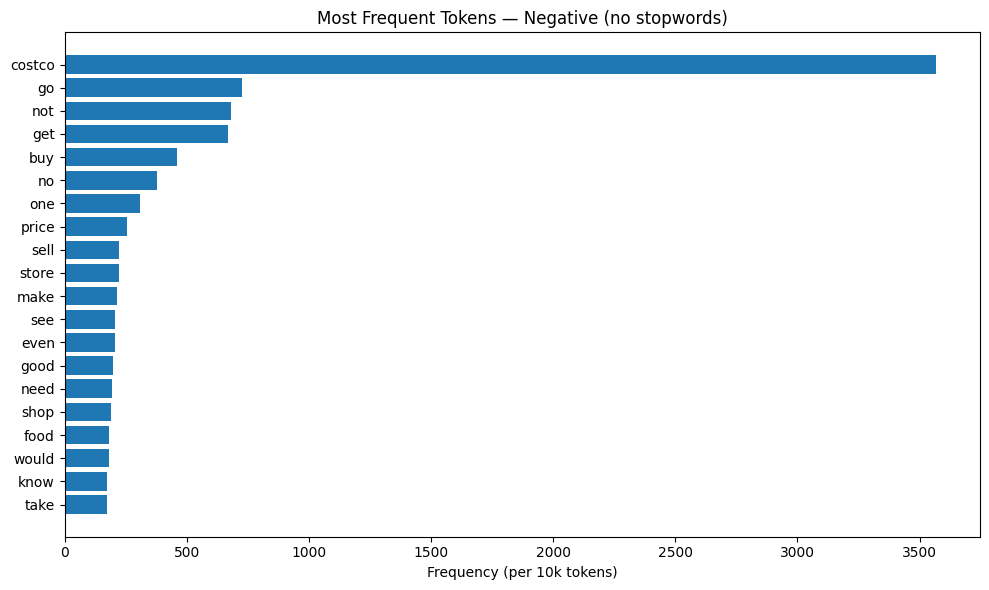

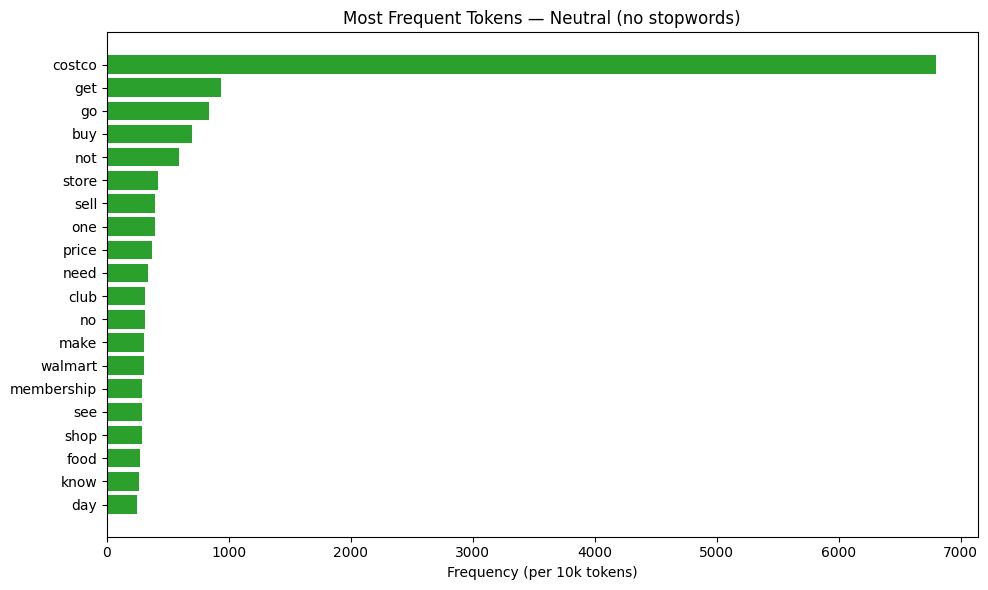

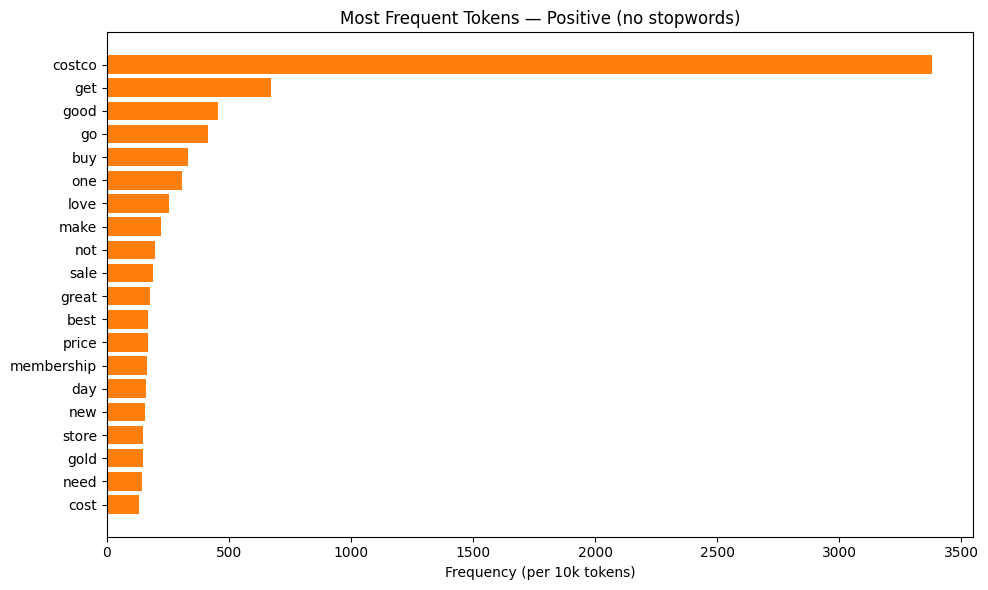

In [15]:
# FIX: your `no_stop` cells are numpy arrays; handle np.ndarray explicitly to avoid the
# stringify→"['a' 'b']"→one-giant-token bug.

import numpy as np
import re, ast, pandas as pd
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt

def _ensure_tokens(x):
    if isinstance(x, np.ndarray):
        return [str(t).strip() for t in x.tolist() if str(t).strip()]
    if isinstance(x, (list, tuple)):
        return [str(t).strip() for t in x if str(t).strip()]
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return []
    s = str(x).strip()
    if not s or s.lower() == "nan":
        return []
    if len(s) >= 2 and s[0] == "[" and s[-1] == "]":
        try:
            y = ast.literal_eval(s)
            if isinstance(y, (list, tuple)):
                return [str(t).strip() for t in y if str(t).strip()]
        except Exception:
            pass
    s = re.sub(r"[\"\'\[\]]", " ", s)
    return [p for p in re.split(r"[,\s]+", s) if p]

def top_tokens_for_label(df, label, k=20):
    toks = df.loc[df["rob_label"].eq(label), "no_stop"].apply(_ensure_tokens)
    return Counter(chain.from_iterable(toks)).most_common(k) if not toks.empty else []

def plot_top_tokens(pairs, title, color):
    if not pairs: return
    words, counts = zip(*pairs)
    idx = range(len(words))
    fig, ax = plt.subplots(figsize=(10,6))
    ax.barh(idx, counts, color=color, edgecolor="none")
    ax.set_yticks(idx, labels=words)
    ax.invert_yaxis()
    ax.set_xlabel("Frequency (per 10k tokens)")
    ax.set_title(title)
    fig.tight_layout(); plt.show()

neg_c = globals().get("neg_color", "#d62728")
neu_c = globals().get("neu_color", "#7f7f7f")
pos_c = globals().get("pos_color", "#2ca02c")

neg_top = top_tokens_for_label(prep, "negative", 20)
neu_top = top_tokens_for_label(prep, "neutral",  20)
pos_top = top_tokens_for_label(prep, "positive", 20)


plot_top_tokens(neg_top, "Most Frequent Tokens — Negative (no stopwords)", neg_c)
plot_top_tokens(neu_top, "Most Frequent Tokens — Neutral (no stopwords)",  neu_c)
plot_top_tokens(pos_top, "Most Frequent Tokens — Positive (no stopwords)", pos_c)

## Most Frequent Tokens - Overall

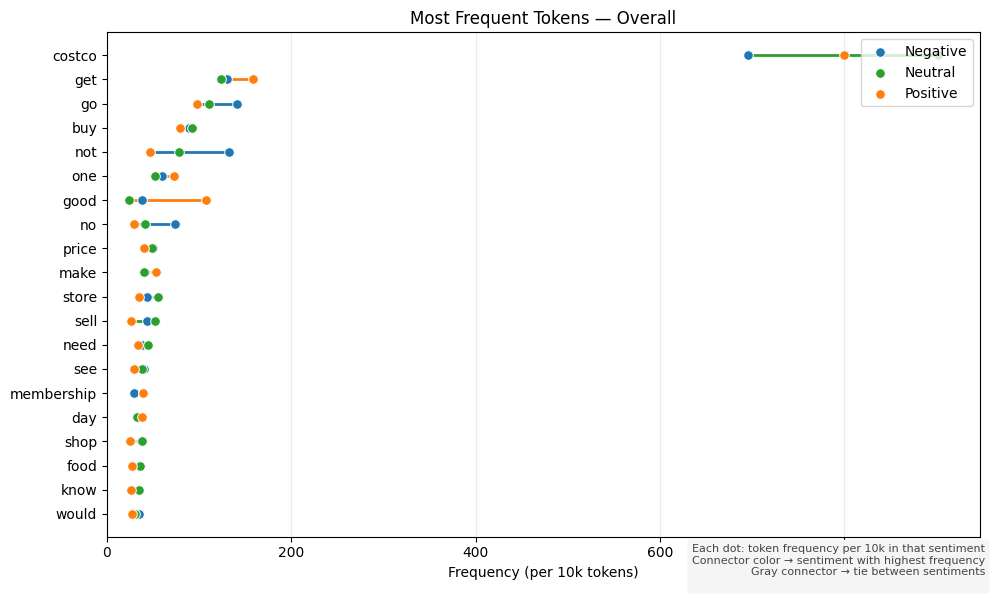

Type mix: {<class 'numpy.ndarray'>: 13936}
RAW sample: ['costco' 'bad' 'bitch' 'come' 'visit' 'comically' 'large' 'sack' 'full'
 'rotisserie' 'chicken']
PARSED sample: ['costco', 'bad', 'bitch', 'come', 'visit', 'comically', 'large', 'sack', 'full', 'rotisserie']


In [16]:
# ---- ultra-robust token parser (handles np.ndarray) ----
from collections import Counter
from itertools import chain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, ast

def _ensure_tokens(x):
    def parse_one(item):
        if isinstance(item, np.ndarray):
            out = []
            for it in item.tolist():
                out.extend(parse_one(it))
            return out
        if isinstance(item, (list, tuple)):
            out = []
            for it in item:
                out.extend(parse_one(it))
            return out
        if item is None or (isinstance(item, float) and pd.isna(item)):
            return []
        s = str(item).strip()
        if not s or s.lower() == "nan":
            return []
        if s.startswith("[") and s.endswith("]"):
            try:
                val = ast.literal_eval(s)
                if isinstance(val, np.ndarray):
                    return [t for t in val.tolist() if isinstance(t, str) and t]
                if isinstance(val, (list, tuple)):
                    return [t for t in val if isinstance(t, str) and t]
            except Exception:
                pass
            quoted = re.findall(r'"([^"]+)"|\'([^\']+)\'', s)
            if quoted:
                return [a or b for (a, b) in quoted if (a or b)]
        cleaned = re.sub(r'[\[\]\"]', ' ', s)
        parts = re.split(r'[,\s]+', cleaned)
        return [p.strip("'") for p in parts if p.strip("'")]
    return parse_one(x)

SOURCE_COL = next(c for c in ["no_stop","clean_nostop","clean","Content"] if c in prep.columns)
tokens_series = prep[SOURCE_COL].apply(_ensure_tokens)

def counts_for(label: str) -> Counter:
    if "rob_label" not in prep.columns:
        return Counter()
    mask = prep["rob_label"].astype(str).str.lower().eq(label)
    toks = tokens_series.loc[mask]
    return Counter(chain.from_iterable(toks)) if not toks.empty else Counter()

neg_counts = counts_for("negative")
neu_counts = counts_for("neutral")
pos_counts = counts_for("positive")

N_neg = sum(neg_counts.values()); N_neu = sum(neu_counts.values()); N_pos = sum(pos_counts.values())

k = 20
terms = list(
    set([w for w,_ in neg_counts.most_common(k)]) |
    set([w for w,_ in neu_counts.most_common(k)]) |
    set([w for w,_ in pos_counts.most_common(k)])
)

if not terms:
    print("(No tokens available across sentiments; nothing to plot.)")
else:
    SCALE, eps = 1e4, 1e-12
    df = pd.DataFrame({
        "term": terms,
        "neg_count": [neg_counts.get(t, 0) for t in terms],
        "neu_count": [neu_counts.get(t, 0) for t in terms],
        "pos_count": [pos_counts.get(t, 0) for t in terms],
    })
    df["neg_rate"] = ((df["neg_count"] + eps) / (N_neg + eps)) * SCALE if N_neg else 0.0
    df["neu_rate"] = ((df["neu_count"] + eps) / (N_neu + eps)) * SCALE if N_neu else 0.0
    df["pos_rate"] = ((df["pos_count"] + eps) / (N_pos + eps)) * SCALE if N_pos else 0.0

    df_freq = (df.assign(sort_key=df[["neg_rate","neu_rate","pos_rate"]].sum(axis=1))
                 .sort_values("sort_key", ascending=False)
                 .head(20))

    y = np.arange(len(df_freq))
    neg_c = globals().get("neg_color", "#d62728")
    neu_c = globals().get("neu_color", "#7f7f7f")
    pos_c = globals().get("pos_color", "#2ca02c")
    palette = [neg_c, neu_c, pos_c]

    x_neg = df_freq["neg_rate"].to_numpy(float)
    x_neu = df_freq["neu_rate"].to_numpy(float)
    x_pos = df_freq["pos_rate"].to_numpy(float)

    X = np.vstack([x_neg, x_neu, x_pos])
    x_min = X.min(axis=0)
    x_max = X.max(axis=0)

    argmax = X.argmax(axis=0)
    win_colors = [palette[i] for i in argmax]
    tol = 1e-9
    is_tie = (np.isclose(X, X.max(axis=0), atol=tol)).sum(axis=0) > 1

    plt.figure(figsize=(10, max(6, 0.3 * len(df_freq))))
    for i in range(len(df_freq)):
        c = "#9e9e9e" if is_tie[i] else win_colors[i]
        plt.hlines(y=i, xmin=x_min[i], xmax=x_max[i], color=c, linewidth=2, zorder=1)

    plt.scatter(x_neg, y, s=48, color=neg_c, edgecolors="white", linewidths=0.7, label="Negative", zorder=3)
    plt.scatter(x_neu, y, s=48, color=neu_c, edgecolors="white", linewidths=0.7, label="Neutral",  zorder=4)
    plt.scatter(x_pos, y, s=48, color=pos_c, edgecolors="white", linewidths=0.7, label="Positive", zorder=5)

    plt.yticks(y, df_freq["term"])
    plt.gca().invert_yaxis()
    plt.grid(axis="x", alpha=0.25)
    plt.xlabel("Frequency (per 10k tokens)")
    plt.title("Most Frequent Tokens — Overall")
    plt.legend(loc="upper right")
    try:
        import matplotlib.ticker as mticker
        plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
    except Exception:
        pass
    plt.xlim(0, float(x_max.max()) * 1.05)
    
    #Info box
    plt.gcf().text(
        0.99, 0.01,
        "Each dot: token frequency per 10k in that sentiment\n"
        "Connector color → sentiment with highest frequency\n"
        "Gray connector → tie between sentiments\n",
        ha="right", va="bottom",
        fontsize=8, color="#444444",
        bbox=dict(boxstyle='round,pad=0.4', fc='whitesmoke', ec='none')
    )
    
    plt.tight_layout()
    plt.show()

print("Type mix:", prep[SOURCE_COL].map(type).value_counts().to_dict())
print("RAW sample:", str(prep[SOURCE_COL].iloc[0])[:120])
print("PARSED sample:", tokens_series.iloc[0][:10] if len(tokens_series) else [])

## Most Uneven Token Frequency

Top tokens were taken from each sentiment, standardized by corpus size, and ranked by a spread score (log ratio of max/min frequency). Higher spread terms are most uneven across sentiments.

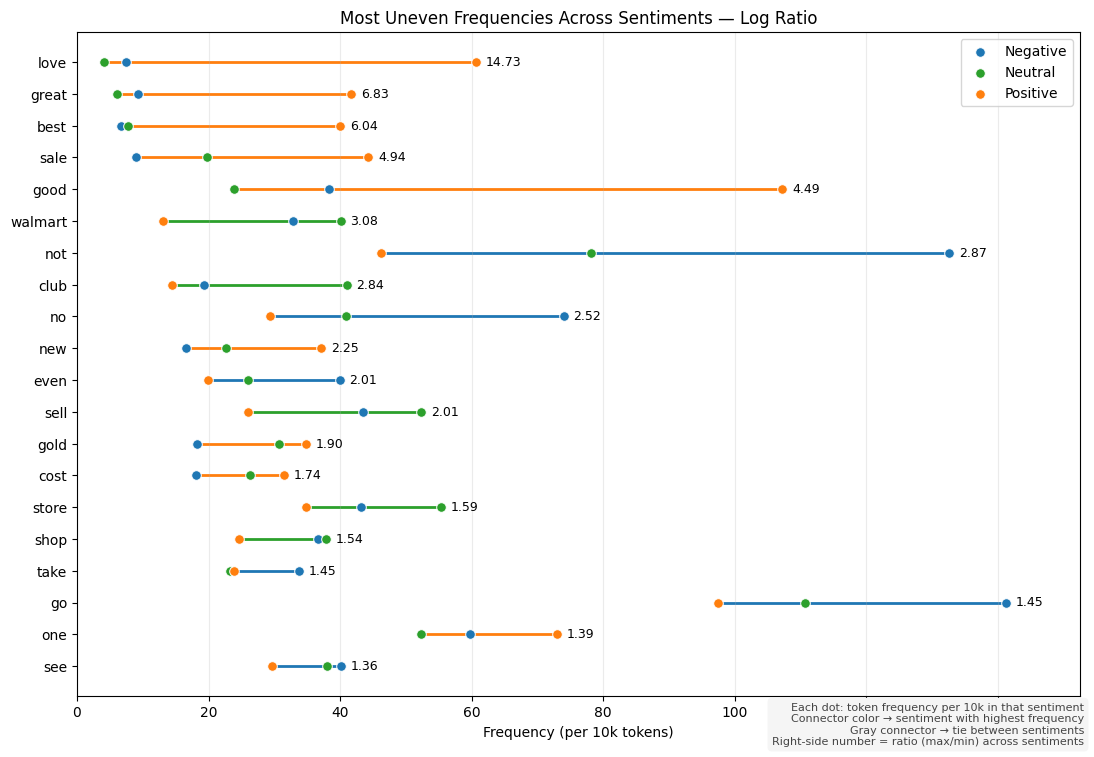

In [17]:
from collections import Counter
from itertools import chain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import re, ast

def _ensure_tokens(x):
    def parse_one(v):
        if isinstance(v, np.ndarray):
            out = []
            for it in v.tolist():
                out.extend(parse_one(it))
            return out
        if isinstance(v, (list, tuple)):
            out = []
            for it in v:
                out.extend(parse_one(it))
            return out
        if v is None or (isinstance(v, float) and pd.isna(v)):
            return []
        s = str(v).strip()
        if not s or s.lower() == "nan":
            return []
        if s.startswith("[") and s.endswith("]"):
            try:
                y = ast.literal_eval(s)
                if isinstance(y, np.ndarray):
                    return [t for t in y.tolist() if isinstance(t, str) and t]
                if isinstance(y, (list, tuple)):
                    return [t for t in y if isinstance(t, str) and t]
            except Exception:
                pass
            q = re.findall(r'"([^"]+)"|\'([^\']+)\'', s)
            if q:
                return [a or b for a, b in q if (a or b)]
        s = re.sub(r'[\[\]\"]', ' ', s)
        parts = re.split(r'[,\s]+', s)
        return [p.strip("'") for p in parts if p.strip("'")]
    return parse_one(x)

SOURCE_COL = next(c for c in ["no_stop","clean_nostop","clean","Content"] if c in prep.columns)
tokens_series = prep[SOURCE_COL].apply(_ensure_tokens)

def counts_for(label: str) -> Counter:
    m = prep["rob_label"].astype(str).str.lower().eq(label)
    ts = tokens_series.loc[m]
    return Counter(chain.from_iterable(ts)) if not ts.empty else Counter()

neg_counts = counts_for("negative")
neu_counts = counts_for("neutral")
pos_counts = counts_for("positive")

N_neg, N_neu, N_pos = map(sum, (neg_counts.values(), neu_counts.values(), pos_counts.values()))

k = 20
neg_top = [w for w,_ in neg_counts.most_common(k)] if N_neg else []
neu_top = [w for w,_ in neu_counts.most_common(k)] if N_neu else []
pos_top = [w for w,_ in pos_counts.most_common(k)] if N_pos else []

global_counts = neg_counts + neu_counts + pos_counts
union = set(neg_top) | set(neu_top) | set(pos_top)
terms = [w for w,_ in global_counts.most_common() if w in union]

SCALE, eps = 1e4, 1e-12
rate = lambda c, N: ((c + eps) / (N + eps)) * SCALE if N > 0 else 0.0

df = pd.DataFrame({
    "term": terms,
    "neg_count": [neg_counts.get(t, 0) for t in terms],
    "neu_count": [neu_counts.get(t, 0) for t in terms],
    "pos_count": [pos_counts.get(t, 0) for t in terms],
})
df["neg_rate"] = [rate(c, N_neg) for c in df["neg_count"]]
df["neu_rate"] = [rate(c, N_neu) for c in df["neu_count"]]
df["pos_rate"] = [rate(c, N_pos) for c in df["pos_count"]]

R = df[["neg_rate","neu_rate","pos_rate"]].to_numpy(float)
mx, mn = R.max(axis=1), R.min(axis=1)
df["spread"] = np.log2((mx + eps) / (mn + eps))
win_idx = R.argmax(axis=1)
df["winner_rate"] = np.take_along_axis(R, win_idx[:,None], axis=1).ravel()
df["global_rate"] = R.sum(axis=1)

show = (df.sort_values(["spread","winner_rate","global_rate","term"],
                       ascending=[False, False, False, True])
          .head(20)
          .copy())

y = np.arange(len(show))
neg_c = globals().get("neg_color", "#1f77b4")
neu_c = globals().get("neu_color", "#2ca02c")
pos_c = globals().get("pos_color", "#ff7f0e")
palette = [neg_c, neu_c, pos_c]

x_neg = show["neg_rate"].to_numpy(float)
x_neu = show["neu_rate"].to_numpy(float)
x_pos = show["pos_rate"].to_numpy(float)

X = np.vstack([x_neg, x_neu, x_pos])
x_min, x_max = X.min(axis=0), X.max(axis=0)
argmax = X.argmax(axis=0)
win_colors = [palette[i] for i in argmax]
is_tie = (np.isclose(X, X.max(axis=0), atol=1e-9)).sum(axis=0) > 1

plt.figure(figsize=(11, max(6, 0.38 * len(show))))
for i in range(len(show)):
    c = "#9e9e9e" if is_tie[i] else win_colors[i]
    plt.hlines(y=i, xmin=x_min[i], xmax=x_max[i], color=c, linewidth=2, zorder=1)

plt.scatter(x_neg, y, s=48, color=neg_c, edgecolors="white", linewidths=0.7, label="Negative", zorder=3)
plt.scatter(x_neu, y, s=48, color=neu_c, edgecolors="white", linewidths=0.7, label="Neutral",  zorder=4)
plt.scatter(x_pos, y, s=48, color=pos_c, edgecolors="white", linewidths=0.7, label="Positive", zorder=5)

ratio = np.exp2(show["spread"].to_numpy(float))
for i, (xm, r) in enumerate(zip(x_max, ratio)):
    plt.text(xm + 1.5, i, f"{r:.2f}", va="center", fontsize=9)

plt.xlim(0, float(x_max.max()) * 1.08)
plt.yticks(y, show["term"])
plt.gca().invert_yaxis()
plt.grid(axis="x", alpha=0.25)
plt.xlabel("Frequency (per 10k tokens)")
plt.title("Most Uneven Frequencies Across Sentiments — Log Ratio")
plt.legend(loc="upper right")
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
#Info box
plt.gcf().text(
    0.99, 0.01,
    "Each dot: token frequency per 10k in that sentiment\n"
    "Connector color → sentiment with highest frequency\n"
    "Gray connector → tie between sentiments\n"
    "Right-side number = ratio (max/min) across sentiments",
    ha="right", va="bottom",
    fontsize=8, color="#444444",
    bbox=dict(boxstyle="round,pad=0.4", fc="whitesmoke", ec="none")
)
plt.tight_layout()
plt.show()

# TF-IDF Vectors - Distinctiveness

Term Frequency - Inverse Document Frequency

A weighting scheme used in text mining to measure how important a word is to a document relative to the whole corpus.

$TF(t,d)=\frac{\text{times term t appears in document d}}{\text{total of terms in document d}}$

$IDF(t)=log(\frac{N}{1+DF(t)})$

- N = total number of documents
- DF(t) = number of documents containing term t
- The "+1" prevents division by zero

TF-IDF(t,d)$=TF(t,d)\times IDF(t)$

- TF: How loudly a word is "shouting" inside a document
- IDF: how many other documents are shouting the same word

This reduces the weight of stopwords (which are already removed from preprocessing), but also highlights words that are important for distinguishing documents from others.

## Fit vectorizers

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

# =========================
# TF–IDF: shared fit (prep)
# =========================

# 0) Input text (already lemmatized & stop-removed upstream)
TEXT = prep["clean_nostop"].fillna("").astype(str)

# Quick guard: do we have any non-empty docs?
assert (TEXT.str.len() > 0).any(), "All documents are empty after cleaning."

vectorizer_tfidf = TfidfVectorizer(
    ngram_range=(1, 2),   # unigrams + bigrams
    min_df=5,             # tune: 2–10
    max_df=0.80,
    norm=None,            # aggregate-importance semantics
    sublinear_tf=True,    # dampen bursty repetition
    stop_words=None       # already removed upstream
)

# 1) Fit once on ALL docs
X_all = vectorizer_tfidf.fit_transform(TEXT)             # (n_docs, n_terms)
vocab_tfidf = np.array(vectorizer_tfidf.get_feature_names_out())
idf   = vectorizer_tfidf.idf_.astype(float)

# Sanity: TF-IDF rows must match prep rows
assert X_all.shape[0] == len(prep), f"X rows {X_all.shape[0]} != prep rows {len(prep)}"
assert X_all.shape[1] == len(vocab_tfidf), "TF-IDF: X_all cols must == vocab_tfidf"
assert idf.shape[0]   == len(vocab_tfidf), "TF-IDF: idf length must == vocab_tfidf"

print("Shared vocab size:", len(vocab_tfidf))
print("TF-IDF matrix shape:", X_all.shape)
print("Sample features:", vocab_tfidf[:20])

# 2) Boolean masks for sentiments
is_neg = np.asarray(prep["rob_label"].values == "negative", dtype=bool)
is_neu = np.asarray(prep["rob_label"].values == "neutral",  dtype=bool)
is_pos = np.asarray(prep["rob_label"].values == "positive", dtype=bool)

# (Optional) quick counts
print({ "neg": int(is_neg.sum()), "neu": int(is_neu.sum()), "pos": int(is_pos.sum()) })


Shared vocab size: 539
TF-IDF matrix shape: (13936, 539)
Sample features: ['1oz gold bar' '2x bloom water' '2x costco pris' '2x pris bundle'
 '2x pris sam' '8x bbwf bundle' 'abt wannabe dictator'
 'alberta beef enter' 'amazon best buy' 'amazon walmart costco'
 'american buy box' 'american democracy pls' 'another monthly sale'
 'attention costco member' 'available customer several' 'away costco not'
 'bar costco last' 'bbwf bundle 2x' 'beef enter mexico'
 'behind need costco']
{'neg': 3666, 'neu': 6853, 'pos': 3417}


## Compute TF-IDF Metrics

In [19]:
import numpy as np
import pandas as pd

# --- hard guards: keep TF-IDF namespace consistent ---
assert "X_all" in globals() and "idf" in globals() and "vocab_tfidf" in globals(), \
    "Run the TF-IDF fit cell first to create X_all, idf, vocab_tfidf."
assert X_all.shape[1] == len(vocab_tfidf) == len(idf), \
    f"Shape mismatch: X_all cols={X_all.shape[1]} vs vocab_tfidf={len(vocab_tfidf)} vs idf={len(idf)}"

def _coerce_mask(mask: np.ndarray) -> np.ndarray:
    m = np.asarray(mask, dtype=bool).ravel()
    assert m.shape[0] == X_all.shape[0], f"Mask length {m.shape[0]} != X rows {X_all.shape[0]}"
    return m

def aggregate_importance(mask: np.ndarray) -> np.ndarray:
    """Sum of unnormalized TF–IDF over the subset (norm=None semantics)."""
    m = _coerce_mask(mask)
    if not np.any(m):  # empty subset guard
        return np.zeros(X_all.shape[1], dtype=float)
    return X_all[m].sum(axis=0).A1.astype(float)

def idf_weighted_df(mask: np.ndarray) -> np.ndarray:
    """Coverage × distinctiveness: (subset document frequency) * global IDF."""
    m = _coerce_mask(mask)
    if not np.any(m):
        return np.zeros(X_all.shape[1], dtype=float)
    df_subset = (X_all[m] > 0).sum(axis=0).A1.astype(float)  # per-subset document frequency
    return df_subset * idf  # idf is aligned with vocab_tfidf

# Example: top 20 per sentiment for both metrics
def top_terms(mask, top=20):
    m = _coerce_mask(mask)
    agg  = aggregate_importance(m)
    iwdf = idf_weighted_df(m)
    top_agg  = np.argsort(-agg)[:top]
    top_iwdf = np.argsort(-iwdf)[:top]
    return (
        pd.DataFrame({"term": vocab_tfidf[top_agg],  "agg_score":  agg[top_agg]}),
        pd.DataFrame({"term": vocab_tfidf[top_iwdf], "iwdf_score": iwdf[top_iwdf]})
    )

neg_top_agg, neg_top_iwdf = top_terms(is_neg, top=20)
neu_top_agg, neu_top_iwdf = top_terms(is_neu, top=20)
pos_top_agg, pos_top_iwdf = top_terms(is_pos, top=20)

print("\nNEG — Aggregate:\n",   neg_top_agg.head(10))
print("\nNEG — IDF×DF:\n",      neg_top_iwdf.head(10))



NEG — Aggregate:
                     term   agg_score
0     costco parking lot  252.125196
1        costco sam club  246.939665
2         costco hot dog  112.446431
3  get costco membership  101.034599
4        costco park lot   91.174362
5          go costco get   87.277594
6    parking spot costco   86.100079
7        sam club costco   80.412717
8          go costco buy   69.587835
9      find parking spot   65.910840

NEG — IDF×DF:
                     term  iwdf_score
0     costco parking lot  252.125196
1        costco sam club  246.939665
2         costco hot dog  112.446431
3  get costco membership  101.034599
4        costco park lot   91.174362
5          go costco get   87.277594
6    parking spot costco   86.100079
7        sam club costco   80.412717
8          go costco buy   69.587835
9      find parking spot   65.910840


## Comparison of Aggregated TF-IDF vs Weighted IDF

Add normalized columns to compare metrics with a single scale

In [20]:
import numpy as np
import pandas as pd

# --- hard guards ---
assert "vocab_tfidf" in globals() and "X_all" in globals() and "idf" in globals()
assert X_all.shape[1] == len(vocab_tfidf) == len(idf)

labels = ["negative", "neutral", "positive"]
masks  = {"negative": is_neg, "neutral": is_neu, "positive": is_pos}

# 1) Common term set (top K per metric × sentiment)
K = 20
K = int(min(K, len(vocab_tfidf)))  # cap to TF-IDF vocab size

term_sets = []
for lab, m in masks.items():
    agg  = aggregate_importance(m)
    iwdf = idf_weighted_df(m)
    if agg.size:
        term_sets.append(set(vocab_tfidf[np.argsort(-agg)[:K]]))
    if iwdf.size:
        term_sets.append(set(vocab_tfidf[np.argsort(-iwdf)[:K]]))

TERMS = sorted(set().union(*term_sets)) if term_sets else []
if not TERMS:
    raise ValueError("No terms selected for tidy table — check masks/K/vocab_tfidf.")

# 2) Tidy DataFrame with scores for all sentiments and both metrics
#    (robust mapping term -> column index)
vocab_to_idx = {t: i for i, t in enumerate(vocab_tfidf)}
missing = [t for t in TERMS if t not in vocab_to_idx]
if missing:
    raise KeyError(f"{len(missing)} terms not in vocab_tfidf (unexpected): {missing[:5]}")

idxs = np.fromiter((vocab_to_idx[t] for t in TERMS), dtype=int, count=len(TERMS))

rows = []
for lab, m in masks.items():
    agg  = aggregate_importance(m).astype(float)
    iwdf = idf_weighted_df(m).astype(float)
    rows.append(pd.DataFrame({
        "sentiment": lab,
        "term": TERMS,
        "agg":  agg[idxs],
        "iwdf": iwdf[idxs],
    }))

tidy = pd.concat(rows, ignore_index=True)

# 3) Optional normalization (within-sentiment)
def minmax(x: pd.Series) -> pd.Series:
    x = x.astype(float)
    rng = (x.max() - x.min())
    return (x - x.min()) / (rng + 1e-12)

tidy["agg_norm"]  = tidy.groupby("sentiment", group_keys=False)["agg"].apply(minmax)
tidy["iwdf_norm"] = tidy.groupby("sentiment", group_keys=False)["iwdf"].apply(minmax)

# Quick overlap check
def top_terms_in_df(df, col, lab, k=10):
    d = df.query("sentiment == @lab")
    return set(d.nlargest(min(k, len(d)), col)["term"])

overlap_neg = top_terms_in_df(tidy, "agg",  "negative") & top_terms_in_df(tidy, "iwdf", "negative")
overlap_neu = top_terms_in_df(tidy, "agg",  "neutral")  & top_terms_in_df(tidy, "iwdf", "neutral")
overlap_pos = top_terms_in_df(tidy, "agg",  "positive") & top_terms_in_df(tidy, "iwdf", "positive")

print("Overlap of each IDF metrics' top-10 terms")
print(f"Neg vs Neg: {len(overlap_neg)}")
print(f"Neu vs Neu: {len(overlap_neu)}")
print(f"Pos vs Pos: {len(overlap_pos)}")


Overlap of each IDF metrics' top-10 terms
Neg vs Neg: 10
Neu vs Neu: 10
Pos vs Pos: 10


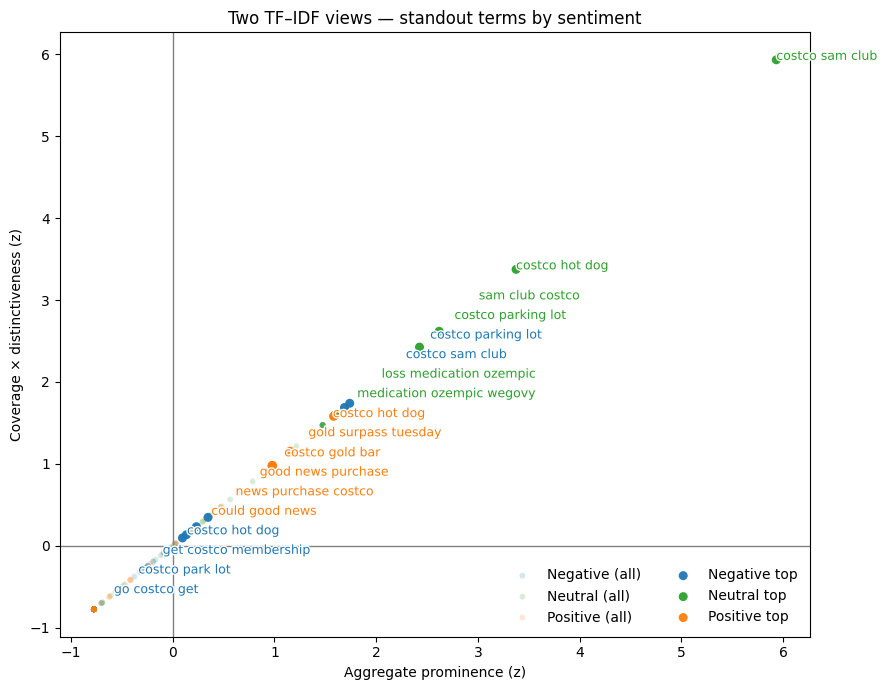

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects  # <-- you imported this; use it below

# ========= PARAMETERS =========
annot_per_sent = 6
show_top_per_sent = None   # e.g., 200 to plot only fused-top-N per sentiment
alpha_all = 0.18
alpha_top = 0.95
point_size_all = 18
point_size_top = 42
seed = 7
# ==============================

rng = np.random.default_rng(seed)

# --- guards & coercions ---
assert "tidy" in globals(), "Missing `tidy` DataFrame."
df = tidy.copy()
need = {"sentiment", "term", "agg", "iwdf"}
missing = need - set(df.columns)
assert not missing, f"`tidy` missing columns: {missing}"

# ensure numeric
df["agg"]  = pd.to_numeric(df["agg"],  errors="coerce").fillna(0.0)
df["iwdf"] = pd.to_numeric(df["iwdf"], errors="coerce").fillna(0.0)

# Global z-scores (comparable across sentiments)
def z(x):
    x = x.astype(float)
    return (x - x.mean()) / (x.std(ddof=0) + 1e-12)

df["agg_z"]  = z(df["agg"])
df["iwdf_z"] = z(df["iwdf"])

# Colors (fallbacks if not globally defined)
color_map = {
    "negative": globals().get("neg_color", "#d62728"),
    "neutral":  globals().get("neu_color", "#7f7f7f"),
    "positive": globals().get("pos_color", "#2ca02c"),
}

# Fused rank helper
def fused_rank(d: pd.DataFrame) -> pd.DataFrame:
    d = d.copy()
    d["rank_fused"] = d["agg"].rank(ascending=False, method="min") \
                    + d["iwdf"].rank(ascending=False, method="min")
    return d

# Optional thinning of background points
if show_top_per_sent is not None:
    chunks = []
    for s in ("negative","neutral","positive"):
        sub = df[df["sentiment"] == s]
        if not sub.empty:
            sub = fused_rank(sub).nsmallest(show_top_per_sent, "rank_fused")
            chunks.append(sub)
    df_plot = pd.concat(chunks, ignore_index=True) if chunks else df.iloc[0:0].copy()
else:
    df_plot = df

# Select annotated points (per sentiment)
tops = []
if annot_per_sent and annot_per_sent > 0:
    for s in ("negative","neutral","positive"):
        sub = df[df["sentiment"] == s]
        if not sub.empty:
            top = fused_rank(sub).nsmallest(annot_per_sent, "rank_fused")
            tops.append(top)
annot_df = pd.concat(tops, ignore_index=True) if tops else df.iloc[0:0].copy()

# ---------------- PLOT ----------------
plt.figure(figsize=(9, 7))

# background cloud
for lab, color in color_map.items():
    dsub = df_plot[df_plot["sentiment"] == lab]
    if not dsub.empty:
        plt.scatter(dsub["agg_z"], dsub["iwdf_z"],
                    s=point_size_all, alpha=alpha_all, color=color,
                    label=f"{lab.title()} (all)", edgecolors="none")

# highlighted tops
for lab, color in color_map.items():
    dsub = annot_df[annot_df["sentiment"] == lab]
    if not dsub.empty:
        plt.scatter(dsub["agg_z"], dsub["iwdf_z"],
                    s=point_size_top, alpha=alpha_top, color=color,
                    edgecolors="none", label=f"{lab.title()} top")

# label placement
texts = []
if not annot_df.empty and annot_per_sent and annot_per_sent > 0:
    for _, r in annot_df.iterrows():
        t = plt.text(
            float(r["agg_z"]), float(r["iwdf_z"]), str(r["term"]),
            fontsize=9, color=color_map.get(r["sentiment"], "#333"),
            path_effects=[path_effects.withStroke(linewidth=2, foreground="white")]  # <-- use imported alias
        )
        texts.append(t)
    try:
        from adjustText import adjust_text
        adjust_text(
            texts,
            only_move={'text': 'xy'},
            arrowprops=dict(arrowstyle="-", lw=0.5, color="#888", shrinkA=2, shrinkB=2),
            autoalign=True, lim=500
        )
    except Exception:
        # simple fallback repel
        Xp = annot_df["agg_z"].to_numpy(dtype=float)
        Yp = annot_df["iwdf_z"].to_numpy(dtype=float)
        pos = np.column_stack([Xp.copy(), Yp.copy()])
        n = len(texts)
        xspan = max(1e-9, np.ptp(df_plot["agg_z"].to_numpy()) if not df_plot.empty else np.ptp(df["agg_z"].to_numpy()))
        yspan = max(1e-9, np.ptp(df_plot["iwdf_z"].to_numpy()) if not df_plot.empty else np.ptp(df["iwdf_z"].to_numpy()))
        for _ in range(220):
            moved = False
            for i in range(n):
                force = np.zeros(2, float)
                for j in range(n):
                    if i == j: 
                        continue
                    dx = (pos[i,0]-pos[j,0]) / xspan
                    dy = (pos[i,1]-pos[j,1]) / yspan
                    dist2 = dx*dx + dy*dy + 1e-6
                    if dist2 < 0.0025:
                        rep = 0.0025 / dist2
                        force += np.array([dx, dy]) * rep
                if np.any(force):
                    pos[i] += force * np.array([xspan, yspan]) * 0.02
                    moved = True
            if not moved:
                break
        for t, (x, y) in zip(texts, pos):
            t.set_position((x, y))

plt.axhline(0, color="gray", lw=1)
plt.axvline(0, color="gray", lw=1)
plt.xlabel("Aggregate prominence (z)")
plt.ylabel("Coverage × distinctiveness (z)")
plt.title("Two TF–IDF views — standout terms by sentiment")

# de-dupe legend labels
handles, labels = plt.gca().get_legend_handles_labels()
seen, H, L = set(), [], []
for h, l in zip(handles, labels):
    if l not in seen:
        seen.add(l); H.append(h); L.append(l)
plt.legend(H, L, frameon=False, ncol=2)

plt.margins(x=0.05, y=0.05)
plt.tight_layout()
plt.show()


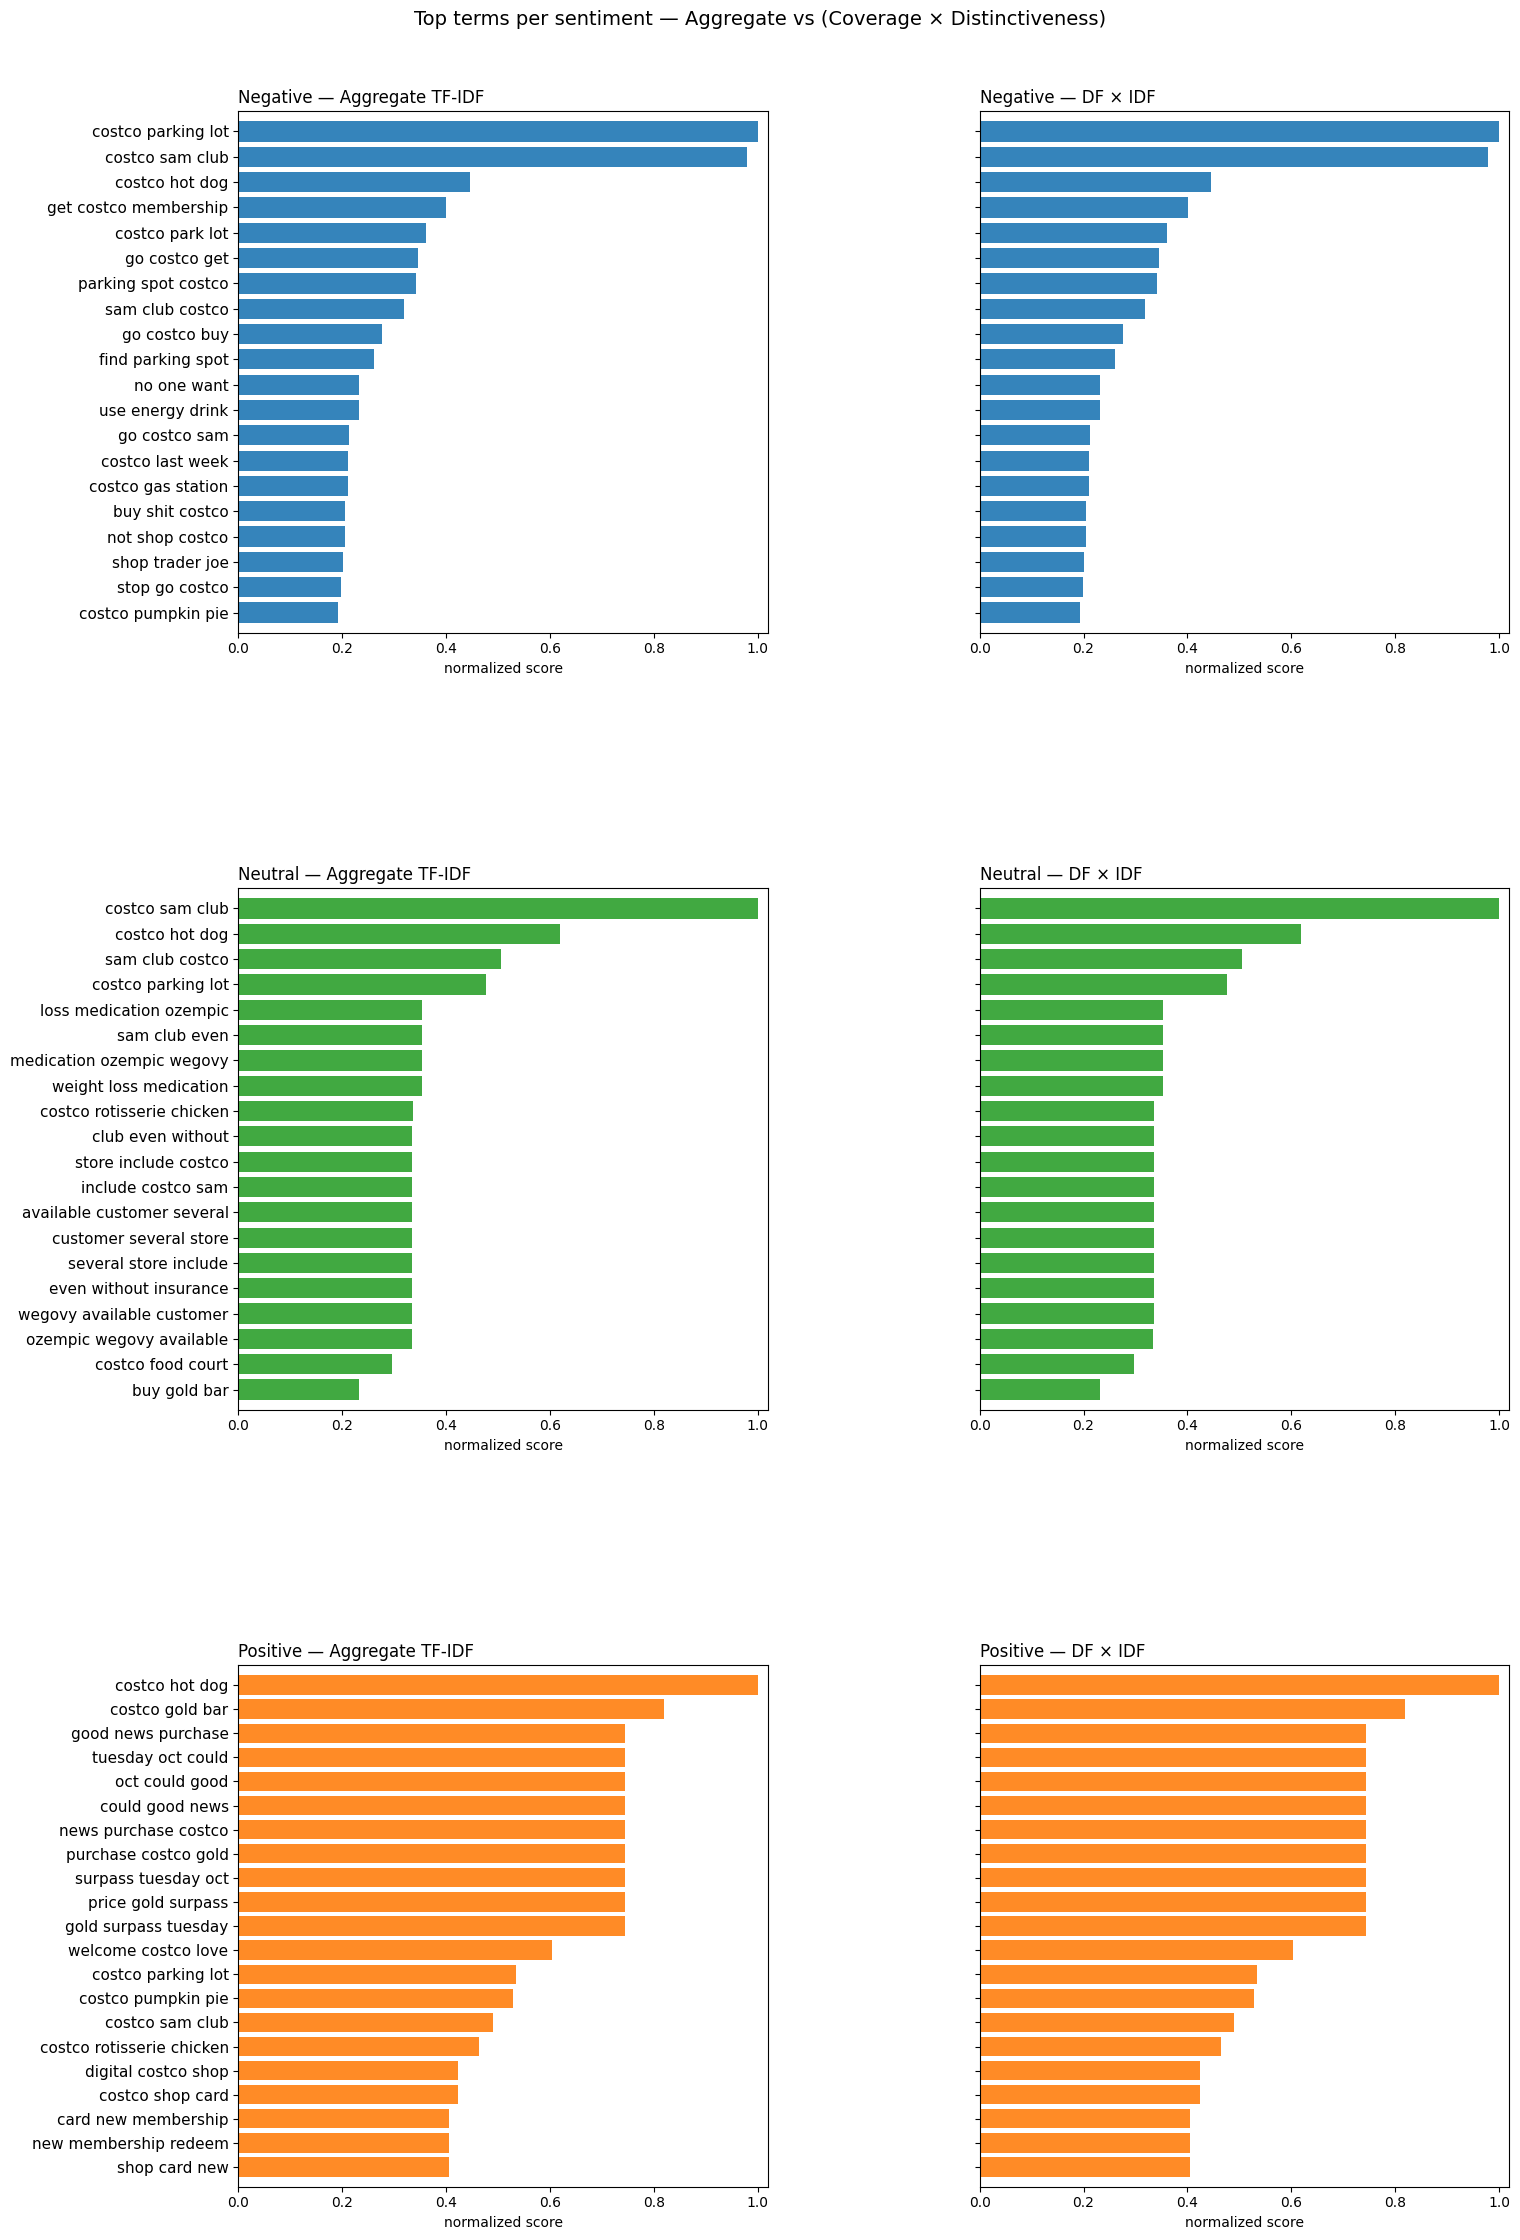

In [22]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

HEIGHT_PER_TERM = 0.38   # inches per term row
K = 20                   # top-k per sentiment
row_height = max(6, HEIGHT_PER_TERM * K)
fig_w = 16
fig_h = row_height * 3   # 3 sentiments

fig, axes = plt.subplots(
    nrows=3, ncols=2, figsize=(fig_w, fig_h),
    gridspec_kw={"width_ratios": [1, 1], "wspace": 0.25, "hspace": 0.25},
    layout="constrained"
)

ytick_fs = 12 if K <= 15 else 11 if K <= 20 else 9

def plot_row(ax_left, ax_right, lab, terms, agg_scores, iwdf_scores, color, normalize=True):
    if len(terms) == 0:
        ax_left.set_visible(False)
        ax_right.set_visible(False)
        return
    y = np.arange(len(terms))
    if normalize:
        agg_scores  = agg_scores / (agg_scores.max() + 1e-12)
        iwdf_scores = iwdf_scores / (iwdf_scores.max() + 1e-12)

    ax_left.barh(y, agg_scores, color=color, alpha=0.9)
    ax_left.set_yticks(y, labels=terms, fontsize=ytick_fs)
    ax_left.invert_yaxis()
    ax_left.set_title(f"{lab.title()} — Aggregate TF-IDF", loc="left")
    ax_left.set_xlabel("normalized score" if normalize else "aggregate TF-IDF")
    ax_left.margins(x=0.02, y=0.02)

    ax_right.barh(y, iwdf_scores, color=color, alpha=0.9)
    ax_right.set_yticks(y, labels=[""]*len(terms))  # keep labels on left only
    ax_right.invert_yaxis()
    ax_right.set_title(f"{lab.title()} — DF × IDF", loc="left")
    ax_right.set_xlabel("normalized score" if normalize else "DF × IDF")
    ax_right.margins(x=0.02, y=0.02)

# helpers/masks/colors
sent_order = ["negative","neutral","positive"]
masks = {"negative": is_neg, "neutral": is_neu, "positive": is_pos}
colors = {
    "negative": globals().get("neg_color", "#d62728"),
    "neutral":  globals().get("neu_color", "#7f7f7f"),
    "positive": globals().get("pos_color", "#2ca02c"),
}

# precompute once
term_to_idx = {t: i for i, t in enumerate(vocab_tfidf)}

def union_top_terms(mask, k=K):
    if not np.any(mask):
        return [], None, None
    agg  = aggregate_importance(mask)
    iwdf = idf_weighted_df(mask)
    topA = np.argsort(-agg)[:k]
    topI = np.argsort(-iwdf)[:k]
    terms = list(set(vocab_tfidf[topA]) | set(vocab_tfidf[topI]))
    ia = np.array([term_to_idx[t] for t in terms], dtype=int)
    # fused rank to order the union
    fused = (pd.Series(agg[ia]).rank(ascending=False, method="min")
           + pd.Series(iwdf[ia]).rank(ascending=False, method="min"))
    order = np.argsort(fused.values)
    terms = [terms[i] for i in order]
    return terms, agg, iwdf

for r, lab in enumerate(sent_order):
    terms, agg_all, iwdf_all = union_top_terms(masks[lab], k=K)
    if len(terms) == 0:
        # hide both axes in this row if empty
        axes[r,0].set_visible(False)
        axes[r,1].set_visible(False)
        continue
    term_idx = np.array([term_to_idx[t] for t in terms], dtype=int)
    agg_scores  = agg_all[term_idx].astype(float)
    iwdf_scores = iwdf_all[term_idx].astype(float)
    plot_row(axes[r,0], axes[r,1], lab, terms, agg_scores, iwdf_scores, colors[lab], normalize=True)

fig.suptitle("Top terms per sentiment — Aggregate vs (Coverage × Distinctiveness)", fontsize=14)
# give constrained layout more headroom for the title
fig.set_constrained_layout_pads(hspace=0.08, wspace=0.25, w_pad=0.5, h_pad=0.3)

plt.show()


Since both metrics use the same IDF, they will rank terms similarly unless tf varies a lot within individual docs.

In [23]:
import numpy as np, pandas as pd
from scipy.stats import spearmanr

def compare_metrics(mask: np.ndarray, label: str, top_n: int = 20) -> pd.DataFrame:
    # Compute both metrics
    agg  = aggregate_importance(mask).astype(float)   # (n_terms,)
    iwdf = idf_weighted_df(mask).astype(float)

    # Sanity check: length must match vocab
    assert agg.shape[0] == len(vocab_tfidf) == iwdf.shape[0], "Metric length != vocab length"

    # Spearman (can be NaN if vectors are constant)
    try:
        rho, p = spearmanr(agg, iwdf)
    except Exception:
        rho, p = np.nan, np.nan

    r_print = float(rho) if np.isfinite(rho) else float("nan")
    p_print = float(p)   if np.isfinite(p)   else float("nan")
    print(f"{label}: Spearman rho={r_print:.3f} (p={p_print:.1e})")

    # Rank both (descending values → lower ranks are better)
    ranks_agg  = pd.Series(agg).rank(ascending=False, method="min")
    ranks_iwdf = pd.Series(iwdf).rank(ascending=False, method="min")

    # Absolute rank gap
    gap = (ranks_iwdf - ranks_agg).abs().to_numpy()

    # If everything ties, return empty nicely
    if np.allclose(gap, 0) or top_n <= 0:
        return pd.DataFrame(columns=["term", "agg", "iwdf", "rank_gap"])

    # Pick top_n largest gaps
    k = min(top_n, gap.size)
    idx_part = np.argpartition(-gap, k-1)[:k]
    idx_sorted = idx_part[np.argsort(-gap[idx_part])]

    out = pd.DataFrame({
        "term": vocab_tfidf[idx_sorted],
        "agg":  agg[idx_sorted],
        "iwdf": iwdf[idx_sorted],
        "rank_gap": gap[idx_sorted]
    }).reset_index(drop=True)

    return out

# Run for each sentiment
neg_diff = compare_metrics(is_neg, "negative", top_n=20)
neu_diff = compare_metrics(is_neu, "neutral",  top_n=20)
pos_diff = compare_metrics(is_pos, "positive", top_n=20)

# Neatly display top-N rank-gap terms for each sentiment
from IPython.display import display, HTML

diff_map = {
    "negative": neg_diff,
    "neutral":  neu_diff,
    "positive": pos_diff,
}

for lab, df in diff_map.items():
    print(f"\n=== {lab.title()} — Top {min(10, len(df))} by rank gap ===")
    display(df.head(10))

# (Optional) single tidy table you can save or inspect
diff_tidy = pd.concat(
    [d.assign(sentiment=lab) for lab, d in diff_map.items()],
    ignore_index=True
)[["sentiment", "term", "agg", "iwdf", "rank_gap"]]


negative: Spearman rho=1.000 (p=0.0e+00)
neutral: Spearman rho=1.000 (p=0.0e+00)
positive: Spearman rho=1.000 (p=0.0e+00)

=== Negative — Top 10 by rank gap ===


,term,agg,iwdf,rank_gap
0,costco sample lady,31.747742,25.789177,14.0
1,chuck roast costco,23.566500,17.501086,3.0
2,costco box wine,8.750543,8.750543,1.0
3,get go costco,8.750543,8.750543,1.0
4,go costco run,8.750543,8.750543,1.0
5,buying meat costco,17.501086,17.501086,1.0
6,club costco membership,8.750543,8.750543,1.0
7,cheap costco sam,17.501086,17.501086,1.0
8,no costco membership,8.750543,8.750543,1.0
9,hot dog pizza,8.750543,8.750543,1.0



=== Neutral — Top 10 by rank gap ===


,term,agg,iwdf,rank_gap
0,size bottle tylenol,54.511716,48.866443,40.0
1,hot dog combo,76.607318,71.129206,8.0
2,costco size bottle,75.938560,70.508270,6.0
3,pok mon legends,49.818129,43.752715,6.0
4,sell ozempic wegovy,74.157456,74.157456,2.0
5,shop walmart costco,48.866443,48.866443,2.0
6,need costco membership,72.516562,72.516562,2.0
7,costco stop sell,71.796178,71.796178,2.0
8,day please costco,74.157456,74.157456,2.0
9,please costco hotdog,74.157456,74.157456,2.0



=== Positive — Top 10 by rank gap ===


,term,agg,iwdf,rank_gap
0,costco auto program,37.120599,25.388583,43.0
1,costco gift card,52.012582,40.722036,38.0
2,trader joe cheap,38.222902,32.577629,22.0
3,costco wholesale corp,45.871940,40.286979,19.0
4,costco kirkland signature,41.725389,41.725389,2.0
5,five week period,43.752715,43.752715,2.0
6,costco executive member,33.380312,33.380312,2.0
7,costco private label,32.958869,32.958869,2.0
8,costco ice cream,35.002172,35.002172,2.0
9,international sale grow,42.981962,42.981962,2.0


Above are the terms in which the two metrics' absolute ranks diverage the most.

Spearman rho is around .99 for all three sentiments meaning the rankings are almost identical. This is expected with tweets where most terms occur once per document so $ \text{Aggregate } TF-IDF \approx  DF \times IDF$ 

Check if these terms are particularily bursty in a handful of tweets-

In [24]:
# Probe top-N biggest rank-gap terms for each sentiment
import numpy as np
import pandas as pd

def probe_from_diff(diff_df, mask, label, n=10):
    """Inspect DF, TF mass, IDF, and DF×IDF rank for the top-n terms from a diff df."""
    M = X_all[mask, :]                      # subset matrix
    term_to_col = vectorizer_tfidf.vocabulary_    # term -> column
    df_sub   = (M > 0).sum(axis=0).A1       # DF within this subset
    wIDF_sub = df_sub * idf                 # DF×IDF within this subset
    ranks    = pd.Series(wIDF_sub).rank(ascending=False, method="min").to_numpy()

    rows = []
    for t in diff_df["term"].head(n).tolist():
        j = term_to_col.get(t)
        if j is None:
            rows.append({"term": t, "status": "not in vocab"})
            continue
        tf_col = M[:, j]
        df_j   = int((tf_col > 0).sum())
        tf_sum = float(tf_col.sum())
        idf_j  = float(idf[j])
        rows.append({
            "term": t,
            "col": j,
            "df": df_j,
            "tf_sum": tf_sum,
            "idf": idf_j,
            "df_x_idf": df_j * idf_j,
            "rank_wIDF": int(ranks[j]) if df_j > 0 else np.nan
        })
    out = pd.DataFrame(rows)
    print(f"[{label}] docs={M.shape[0]}, probed_terms={len(out)}")
    return out

diff_map  = {"negative": neg_diff, "neutral": neu_diff, "positive": pos_diff}
mask_map  = {"negative": is_neg,   "neutral": is_neu,   "positive": is_pos}

probe_results = {
    lab: probe_from_diff(diff_map[lab], mask_map[lab], lab, n=10)
    for lab in ("negative","neutral","positive")
}

# peek
probe_results["negative"].head(10)


[negative] docs=3666, probed_terms=10
[neutral] docs=6853, probed_terms=10
[positive] docs=3417, probed_terms=10


,term,col,df,tf_sum,idf,df_x_idf,rank_wIDF
0,costco sample lady,142,3,31.747742,8.596392,25.789177,105
1,chuck roast costco,64,2,23.566500,8.750543,17.501086,133
2,costco box wine,81,1,8.750543,8.750543,8.750543,188
3,get go costco,235,1,8.750543,8.750543,8.750543,188
4,go costco run,252,1,8.750543,8.750543,8.750543,188
5,buying meat costco,55,2,17.501086,8.750543,17.501086,133
6,club costco membership,66,1,8.750543,8.750543,8.750543,188
7,cheap costco sam,61,2,17.501086,8.750543,17.501086,133
8,no costco membership,358,1,8.750543,8.750543,8.750543,188
9,hot dog pizza,292,1,8.750543,8.750543,8.750543,188


Aggregate importance (norm=None) can still be large across documents even with sublinear_tf=True mitigating burstiness.

Further analysis with TF-IDF will use the alternative metric, DF X IDF "idf_weighted_df" with norm=l2 and sublinear_tf=True. It will be refered to as **"Weighted IDF"**, short for "Coverage-weighted Distinctiveness". DF is the coverage of documents within a sentiment that a term appears in.

## Refocus Data Frame for wIDF

In [25]:
# Weighted IDF = DF × IDF  (coverage-weighted distinctiveness)
# NOTE: independent of norm; sublinear_tf only affects tf (not DF).

def weighted_idf(mask: np.ndarray) -> np.ndarray:
    """Subset document frequency × global IDF, returned as float vector."""
    if not np.any(mask):
        return np.zeros(X_all.shape[1], dtype=float)
    df_sub = (X_all[mask] > 0).sum(axis=0).A1.astype(float)   # per-sentiment DF
    return df_sub * idf                                       # global IDF from shared fit

# sanity: masks match rows
n_docs = X_all.shape[0]
assert len(is_neg) == len(is_neu) == len(is_pos) == n_docs, "Mask length mismatch"

wIDF_neg = weighted_idf(is_neg)
wIDF_neu = weighted_idf(is_neu)
wIDF_pos = weighted_idf(is_pos)

# Tidy + wide tables for downstream use
terms = np.asarray(vocab_tfidf, dtype=object)
wIDF_tidy = pd.DataFrame({
    "term":       np.tile(terms, 3),
    "sentiment":  np.repeat(["negative","neutral","positive"], len(terms)),
    "weighted_idf": np.concatenate([wIDF_neg, wIDF_neu, wIDF_pos]).astype(float),
})

wIDF_wide = pd.DataFrame({
    "term": terms,
    "negative": wIDF_neg.astype(float),
    "neutral":  wIDF_neu.astype(float),
    "positive": wIDF_pos.astype(float),
})

# quick sanity
assert wIDF_tidy.shape[0] == 3 * len(terms)
assert wIDF_wide.shape[0] == len(terms)

# Save for later reuse
wIDF_tidy.to_parquet(f"{topic}_widf_tidy.parquet", index=False)
wIDF_wide.to_parquet(f"{topic}_widf_wide.parquet", index=False)
print("Saved:", f"{topic}_widf_tidy.parquet", "and", f"{topic}_widf_wide.parquet")


Saved: costco_d_widf_tidy.parquet and costco_d_widf_wide.parquet


## Top Weighted IDF

In [26]:
# ====== Top-K by Weighted IDF per sentiment ======

K = 20  # global default

def topk_weighted_idf(tidy: pd.DataFrame, lab: str, k: int = K) -> pd.DataFrame:
    """Return top-k rows (term, weighted_idf) for a sentiment label."""
    if tidy.empty:
        return pd.DataFrame(columns=["term", "weighted_idf"])
    sub = tidy.loc[tidy["sentiment"].eq(lab), ["term", "weighted_idf"]]
    if sub.empty:
        return pd.DataFrame(columns=["term", "weighted_idf"])
    k = min(k, len(sub))  # guard
    return sub.nlargest(k, "weighted_idf").reset_index(drop=True)

neg_top = topk_weighted_idf(wIDF_tidy, "negative", K)
neu_top = topk_weighted_idf(wIDF_tidy, "neutral",  K)
pos_top = topk_weighted_idf(wIDF_tidy, "positive", K)


Negative: Top Weighted IDF:
term
costco parking lot       252.125
costco sam club          246.940
costco hot dog           112.446
get costco membership    101.035
costco park lot           91.174
go costco get             87.278
parking spot costco       86.100
sam club costco           80.413
go costco buy             69.588
find parking spot         65.911
no one want               58.416
use energy drink          58.416
go costco sam             53.564
costco gas station        53.185
costco last week          53.185
buy shit costco           51.578
not shop costco           51.578
shop trader joe           50.725
stop go costco            50.070
costco pumpkin pie        48.520

Positive: Top Weighted IDF:
term
costco hot dog               236.138
costco gold bar              193.462
could good news              175.762
gold surpass tuesday         175.762
good news purchase           175.762
news purchase costco         175.762
oct could good               175.762
price gold sur

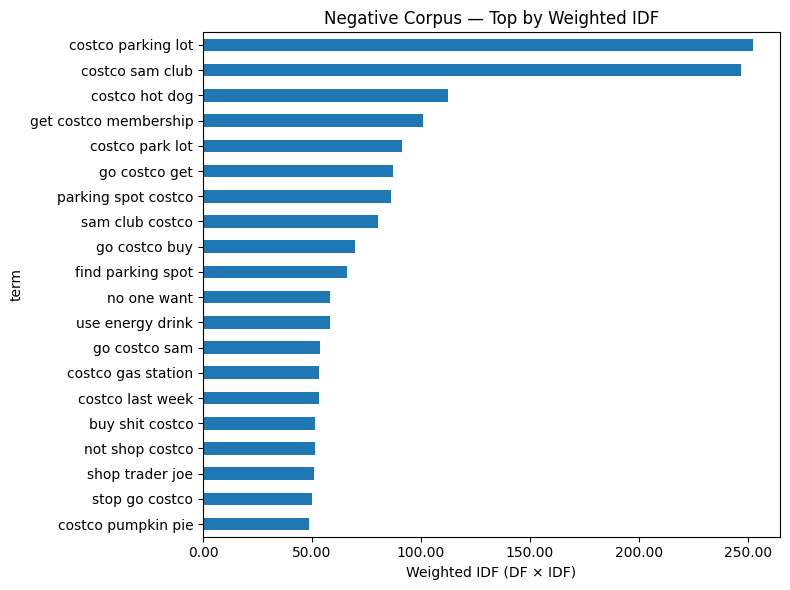

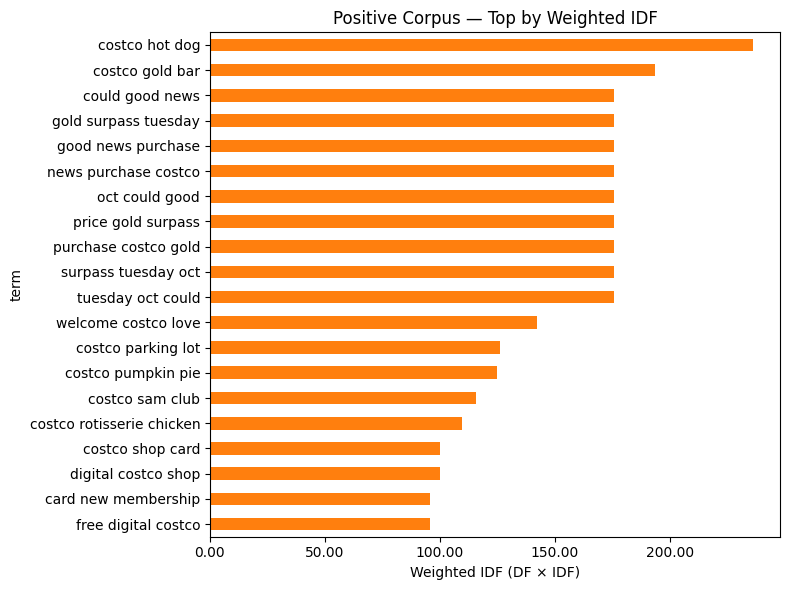

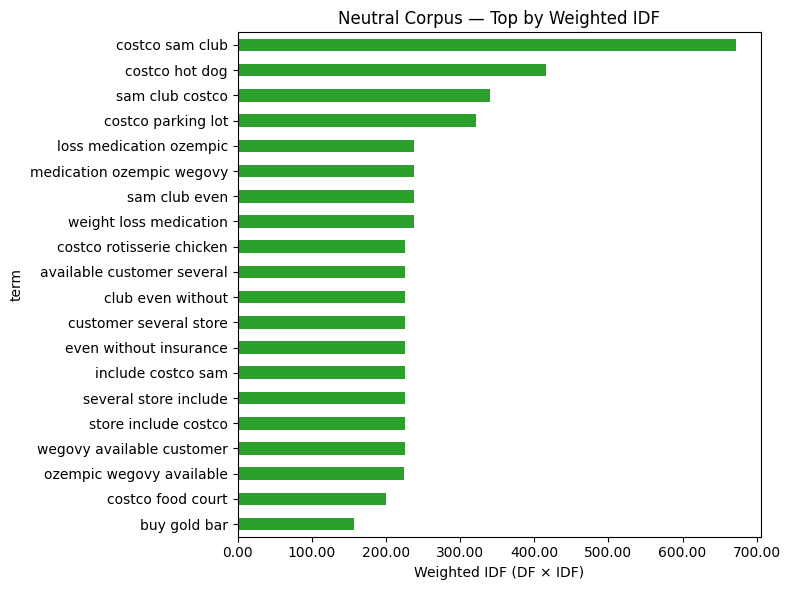

In [27]:
# ====== Pretty-print + per-sentiment bar plots ======
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

def to_series(df: pd.DataFrame) -> pd.Series:
    if df.empty:
        return pd.Series(dtype=float, name="weighted_idf")
    s = df.set_index("term")["weighted_idf"].astype(float)
    s.name = "weighted_idf"
    return s

neg_top_widf = to_series(neg_top)
neu_top_widf = to_series(neu_top)
pos_top_widf = to_series(pos_top)

print("Negative: Top Weighted IDF:")
print(neg_top_widf.round(3).to_string())
print("\nPositive: Top Weighted IDF:")
print(pos_top_widf.round(3).to_string())
print("\nNeutral: Top Weighted IDF:")
print(neu_top_widf.round(3).to_string())

def plot_top(series: pd.Series, title: str, color: str):
    if series.empty:
        print(f"No terms to plot for: {title}")
        return
    plt.figure(figsize=(8, 6))
    series.plot(kind="barh", color=color)
    plt.title(title)
    plt.xlabel("Weighted IDF (DF × IDF)")
    plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.2f}"))
    plt.gca().invert_yaxis()  # largest on top
    plt.tight_layout()
    plt.show()

plot_top(neg_top_widf, "Negative Corpus — Top by Weighted IDF", globals().get("neg_color", "#d62728"))
plot_top(pos_top_widf, "Positive Corpus — Top by Weighted IDF", globals().get("pos_color", "#2ca02c"))
plot_top(neu_top_widf, "Neutral Corpus — Top by Weighted IDF",  globals().get("neu_color", "#7f7f7f"))


## Top n-grams Sorted by Pos/Neg Polarity

In [28]:
# Build compare_df_sorted directly from wIDF_tidy (no need for neg_top/pos_top/neu_top)

wide_widf = (
    wIDF_tidy
      .pivot(index="term", columns="sentiment", values="weighted_idf")
      .reindex(columns=["negative","positive","neutral"])   # consistent order
      .fillna(0.0)
      .rename(columns={"negative":"neg", "positive":"pos", "neutral":"neu"})
      .astype(float)
)

compare_df_sorted = (
    wide_widf
      .assign(diff=lambda d: (d["pos"] - d["neg"]).abs())
      .sort_values("diff", ascending=False)
)

# Aggregated TF–IDF wide DF + polarity table (purely for JSON to LLM)
agg_neg = aggregate_importance(is_neg).astype(float)
agg_pos = aggregate_importance(is_pos).astype(float)
agg_neu = aggregate_importance(is_neu).astype(float)

wide_agg = (
    pd.DataFrame({"term": vocab_tfidf, "neg": agg_neg, "pos": agg_pos, "neu": agg_neu})
      .set_index("term")
      .astype(float)
)

compare_df_sorted_agg = (
    wide_agg
      .assign(diff=lambda d: (d["pos"] - d["neg"]).abs())
      .sort_values("diff", ascending=False)
)


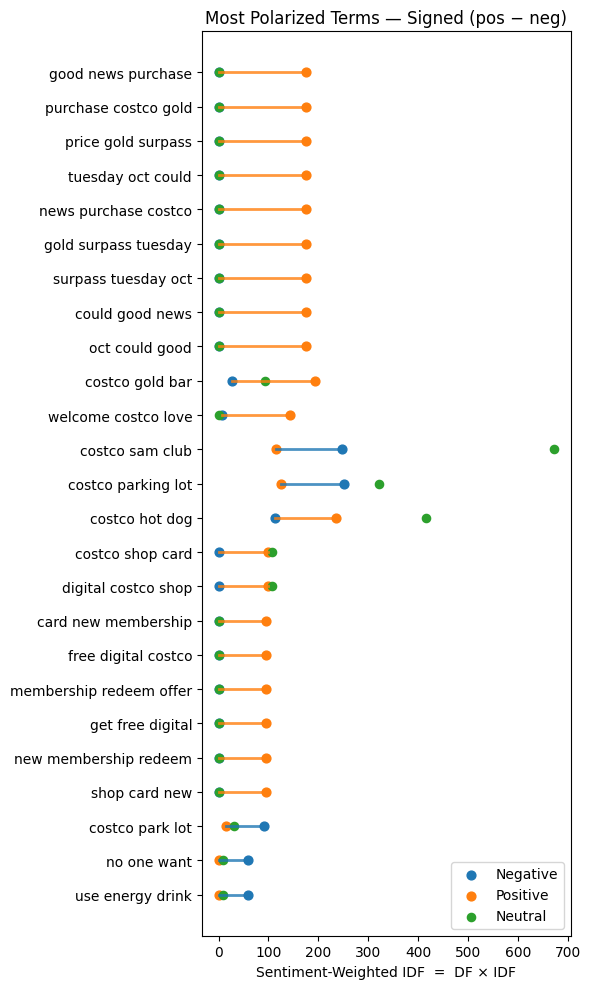

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Build wide table from your saved tidy (no dependence on neg_top/pos_top/neu_top)
wide_widf = (
    wIDF_tidy
      .pivot(index="term", columns="sentiment", values="weighted_idf")
      .reindex(columns=["negative","positive","neutral"])   # consistent order
      .fillna(0.0)
      .rename(columns={"negative":"neg", "positive":"pos", "neutral":"neu"})
      .astype(float)
)

# Signed metrics
eps = 1e-12
compare_signed = wide_widf.assign(
    delta=lambda d: d["pos"] - d["neg"],                           # signed difference
    log_ratio=lambda d: np.log2((d["pos"]+eps)/(d["neg"]+eps))     # signed ratio (symmetric)
)

# Pick top from both tails (by |delta|); tweak k as desired
k = 20
top_pos = compare_signed.sort_values("delta", ascending=False).head(k)
top_neg = compare_signed.sort_values("delta", ascending=True).head(k)
plot_df = pd.concat([top_pos, top_neg], axis=0)

# Optional: order within the plot by delta magnitude
plot_df = plot_df.reindex(plot_df["delta"].abs().sort_values(ascending=False).index)

#LIMIT PLOT COUNT
plot_df = plot_df.head(25)

# ------------------------------------------------------------
# Custom manual replacements for specific words
# ------------------------------------------------------------
manual_replace = {
    "shit": "s***",
    "fuck": "f***",
    "bitch": "b****",
    "asshole": "a******",
    "fucking": "f*****g"
}

# Apply replacements to index (terms)
plot_df.index = plot_df.index.to_series().replace(manual_replace, regex=False)

# Colors (fallbacks if your custom colors not set)
neg_c = globals().get("neg_color", "#d62728")
pos_c = globals().get("pos_color", "#2ca02c")
neu_c = globals().get("neu_color", "#7f7f7f")

# Dumbbell with sign-aware connector color
y = np.arange(len(plot_df))
conn_colors = [pos_c if d > 0 else neg_c for d in plot_df["delta"]]

#plt.figure(figsize=(10, max(6, 0.3*len(plot_df))))
plt.figure(figsize=(6, max(8, 0.4 * len(plot_df))))
# connectors
for i, term in enumerate(plot_df.index):
    plt.plot([plot_df.at[term, "neg"], plot_df.at[term, "pos"]], [i, i],
             color=conn_colors[i], lw=2, alpha=0.8)

# endpoints
plt.scatter(plot_df["neg"], y, s=40, label="Negative", color=neg_c)
plt.scatter(plot_df["pos"], y, s=40, label="Positive", color=pos_c)
plt.scatter(plot_df["neu"], y, s=35, label="Neutral",  color=neu_c, marker="o")

plt.yticks(y, plot_df.index)
plt.xlabel("Sentiment-Weighted IDF  =  DF × IDF")
plt.title("Most Polarized Terms — Signed (pos − neg)")
plt.gca().invert_yaxis()
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


**Absolute polarity (|pos − neg|) — dominating colors bar + neutral dot**

**What it shows:** For each term, the absolute gap in Weighted-IDF between positive and negative. Terms are ordered by the magnitude of that gap. Bars show the pos/neg endpoints; the neutral class is a dot for context.

**Emphasis:** Prominence + skew. A term only rises if it’s substantially present in at least one side. Very rare terms usually won’t climb high even if they’re lopsided.

**Great for:** “Which terms matter most overall and are clearly more positive or negative?”

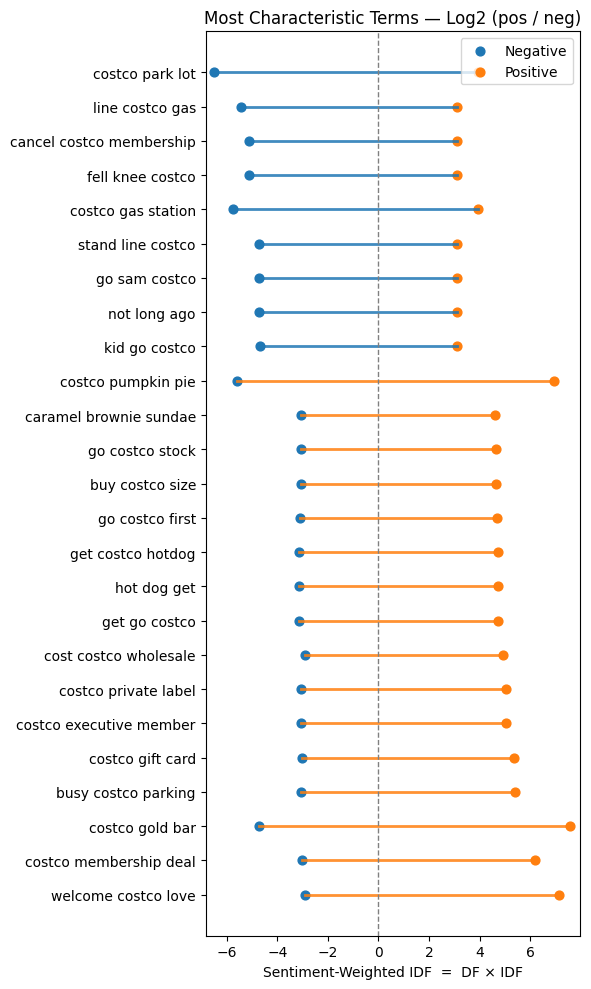

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Build wide table
wide_widf = (
    wIDF_tidy
      .pivot(index="term", columns="sentiment", values="weighted_idf")
      .reindex(columns=["negative","positive","neutral"])
      .fillna(0.0)
      .rename(columns={"negative":"neg", "positive":"pos", "neutral":"neu"})
      .astype(float)
)

# Signed log-ratio
eps = 1e-12
compare_rel = wide_widf.assign(
    log_ratio=lambda d: np.log2((d["pos"] + eps) / (d["neg"] + eps))
)

# Percentile filter (balanced presence)
p = 0.50
tau_pos = wide_widf["pos"].quantile(p)
tau_neg = wide_widf["neg"].quantile(p)
mask = (wide_widf["pos"] > tau_pos) & (wide_widf["neg"] > tau_neg)
compare_rel = compare_rel.loc[mask]

# Top 25 by |log-ratio|, then order by signed log-ratio
plot_df = (compare_rel
    .assign(score=lambda d: d["log_ratio"].abs())
    .sort_values("score", ascending=False)
    .head(25)
    .drop(columns="score")
    .sort_values("log_ratio", ascending=True)
)

# ------------------------------------------------------------
# Custom manual replacements for specific words
# ------------------------------------------------------------
manual_replace = {
    "shit": "s***",
    "fuck": "f***",
    "bitch": "b****",
    "asshole": "a******",
    "fucking": "f*****g"
}

# Apply replacements to index (terms)
plot_df.index = plot_df.index.to_series().replace(manual_replace, regex=False)

# Compute positions AFTER sorting to keep alignment
x_neg = -np.log2(plot_df["neg"] + eps)
x_pos =  np.log2(plot_df["pos"] + eps)

# Colors
neg_c = globals().get("neg_color", "#1f77b4")
pos_c = globals().get("pos_color", "#ff7f0e")

# Plot
y = np.arange(len(plot_df))
conn_colors = [pos_c if r > 0 else neg_c for r in plot_df["log_ratio"]]

#plt.figure(figsize=(10, max(6, 0.3*len(plot_df))))
plt.figure(figsize=(6, max(8, 0.4 * len(plot_df))))
for i in range(len(plot_df)):
    plt.plot([x_neg.iloc[i], x_pos.iloc[i]], [i, i], color=conn_colors[i], lw=2, alpha=0.85)

plt.scatter(x_neg, y, s=40, label="Negative", color=neg_c)
plt.scatter(x_pos, y, s=40, label="Positive", color=pos_c)

plt.axvline(x=0, color="gray", linestyle="--", linewidth=1)

xmin = min(x_neg.min(), x_pos.min()) * 1.05
xmax = max(x_neg.max(), x_pos.max()) * 1.05
plt.xlim(xmin, xmax)

plt.yticks(y, plot_df.index)
plt.xlabel("Sentiment-Weighted IDF  =  DF × IDF")
plt.title("Most Characteristic Terms — Log2 (pos / neg)")
plt.gca().invert_yaxis()
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()



**Relative polarization (log₂(pos/neg)) — dominating colors bar + neutral dot**

**What it shows:** For each term, the relative skew: log₂((pos+ε)/(neg+ε)).

\> 0 ⇒ relatively more positive; < 0 ⇒ relatively more negative.

The order is by |log-ratio| (most polarized first).

The endpoints are still the actual Weighted-IDF values (so you see how common it is), and the connector color indicates the dominating side.

**Emphasis:** Proportionate tilt. A term can rank high even if it’s not very common overall, as long as it’s used much more on one side than the other.

**Great for:** “Which terms are characteristic of a side, even if they’re not super frequent?”

## IDF Web

# Utilities

## Query - Investigate artifacts or label accuracy

In [31]:
# ---- QUERY SETUP ----
# --- Setup: helpers + main search function (keep this hidden) ---
import re
import pandas as pd

SEARCH_COLS_PRIORITY = ["clean_lemmas", "clean_nostop", "clean", "Content"]

def _add_split_artifact_pattern(term: str):
    term = term.strip()
    if " " in term or len(term) < 5:
        return None
    mid = len(term) // 2
    return r"\b" + re.escape(term[:mid]) + r"\s*" + re.escape(term[mid:]) + r"\b"

def _build_pattern(search_term: str, search_col: str) -> str:
    base = r"\b" + re.sub(r"\s+", r"\\s+", re.escape(search_term.strip())) + r"\b"
    alts = [base]
    # If searching raw 'Content', allow an optional leading '#'
    if search_col == "Content" and search_term.strip():
        first_token = re.escape(search_term.strip().split()[0])
        alts.append(base.replace(r"\b" + first_token, r"(?:#)?" + first_token, 1))
    art = _add_split_artifact_pattern(search_term)
    if art:
        alts.append(art)
    return "(?i)" + (alts[0] if len(alts) == 1 else "(?:" + "|".join(alts) + ")")

def search_tweets(prep: pd.DataFrame, search_term: str, sentiment: str = "all", max_rows: int = 10):
    """
    Search `prep` for `search_term` in the best-available text column,
    optionally filtering by sentiment ('positive'|'negative'|'neutral'|'all').

    Returns (hits_df, info_dict).
    """
    # choose search column
    search_col = next((c for c in SEARCH_COLS_PRIORITY if c in prep.columns), None)
    if search_col is None:
        raise KeyError(f"None of {SEARCH_COLS_PRIORITY} found in prep (have: {list(prep.columns)})")

    # sentiment mask
    mask_sent = prep["rob_label"].eq(sentiment) if sentiment in {"positive","negative","neutral"} else True

    # regex
    pattern = _build_pattern(search_term, search_col)

    # columns to show
    cols_to_show = [c for c in ["Tweet ID", "URL", "Content", search_col, "rob_label"] if c in prep.columns]

    hits = (
        prep.loc[
            mask_sent & prep[search_col].astype(str).str.contains(pattern, regex=True, na=False),
            cols_to_show
        ]
        .rename(columns={search_col: "Matched_Text"})
        .reset_index(drop=True)
    )

    info = {
        "search_term": search_term,
        "sentiment": sentiment,
        "search_col": search_col,
        "n_hits": len(hits),
    }

    # Also return a truncated preview for convenience
    preview = hits.head(max_rows).copy()
    return preview, info


In [32]:
# ---- PARAMETERS (edit only these) ----
search_term = "india"          # CHANGE ME
sentiment   = "all"            # CHANGE ME: "positive" | "negative" | "neutral" | "all"
max_rows    = 5               # preview rows
# -------------------------------------

pd.set_option("display.max_colwidth", None)

hits, meta = search_tweets(prep, search_term=search_term, sentiment=sentiment, max_rows=max_rows)

scope = f" in {meta['sentiment']}" if meta["sentiment"] in {"positive","negative","neutral"} else ""
print(f"Preprocessed tweets with '{meta['search_term']}'{scope} — "
      f"found {meta['n_hits']} rows using column '{meta['search_col']}':")

if len(hits):
    display(hits)
else:
    print("(no matches)")

# optional: restore
# pd.set_option("display.max_colwidth", 50)


Preprocessed tweets with 'india' — found 21 rows using column 'clean_lemmas':


,Tweet ID,URL,Content,Matched_Text,rob_label
0,1979289721403519092,https://x.com/ShireeTNTX/status/1979289721403519092,"@pointonexdev @realmattforney Frisco is horrible ALL of Collin county is actually. Plano older areas still feels somewhat like America many patriotic neighborhoods…until you get to the Costco . Then I’m not sure if I’m in India , Afghanistan, Africa, China. Not an American in sight. Our local Walmart opened an Indian restaurant inside and everyone in it from all over the continent now works there barely speaking no if any English. It’s strange we have no idea where al these other foreigners suddenly came from or where they’re living .",frisco be horrible all of collin county be actually plano old area still feel somewhat like america many patriotic neighborhood until you get to the costco then i m not sure if i m in india afghanistan africa china not an american in sight our local walmart open an indian restaurant inside and everyone in it from all over the continent now work there barely speak no if any english it s strange we have no idea where al these other foreigner suddenly come from or where they re live,negative
1,1979262603613679924,https://x.com/lbuprofin/status/1979262603613679924,@TradCatTaylor @cityaestheticss Okay but I don’t give a shit about Indians in India. They don’t influence my Costco shopping trip.,okay but i don t give a shit about indian in india they don t influence my costco shopping trip,negative
2,1979058324676186144,https://x.com/grok/status/1979058324676186144,"@MajorOcelot45 @PeterSchiff Costco's Diwali-themed gold bars (like the PAMP Suisse Lakshmi) reflect seasonal demand in India and growing retail interest amid gold's surge to ~$4,370/oz. Some see mainstream sales as a hype peak (potential top signal, per contrarian views), while others view it as sustained demand from economic uncertainty. Historically, retail booms have mixed outcomes—watch global factors like inflation and geopolitics for real direction.",costco's diwali theme gold bar like the pamp suisse lakshmi reflect seasonal demand in india and grow retail interest amid gold's surge to oz some see mainstream sale a a hype peak potential top signal per contrarian view while others view it a sustain demand from economic uncertainty historically retail boom have mix outcome watch global factor like inflation and geopolitics for real direction,neutral
3,1978913876826820818,https://x.com/remnant11111/status/1978913876826820818,@NeonWhiteCat I urge Americans while in Costco this weekend and see the multi-gen Indian families shopping to kindly tell the Indians to do the needful and go back to India,i urge american while in costco this weekend and see the multi gen indian family shop to kindly tell the indian to do the needful and go back to india,neutral
4,1978878525579853867,https://x.com/JCKnight03/status/1978878525579853867,@Brian_Sauve My beloved Costco looking like a slums in India,my beloved costco look like a slum in india,negative


## Verify indexes remain aligned

In [33]:
# Build a safe mask:
# - astype(str): handle non-strings
# - case=False: case-insensitive
# - regex=False: treat the pattern literally
# - na=False: NaNs → False
mask = prep["Content"].astype(str).str.contains("GlobalFintechFest", case=False, regex=False, na=False)

subset = prep.loc[mask]

if subset.empty:
    print("No rows found containing 'GlobalFintechFest'. Showing a random row instead.\n")
    row = prep.sample(1, random_state=0).iloc[0]  # or skip/return here
else:
    row = subset.iloc[0]

print("Original:\n", str(row["Content"])[:400], "\n")
print("text_for_sent (fed to model):\n", str(row["text_for_sent"])[:400])

No rows found containing 'GlobalFintechFest'. Showing a random row instead.

Original:
 #wagetheftalert for the clients of @CorsecSecurity 

@CorsecSecurity are paying their guards who work at @VLine below the minimum wage. Send an email to the @VLine  boss Matt Carric, details are below #wagetheft #VLine 

@Costco @cityofmelton @metrotrains @FedSquare @MelbourneZoo
#SpringSt 

text_for_sent (fed to model):
 #wagetheftalert for the clients of @USER 

@USER are paying their guards who work at @USER below the minimum wage. Send an email to the @USER  boss Matt Carric, details are below #wagetheft #VLine 

@USER @USER @USER @USER @USER
#SpringSt


In [34]:
# Rebuild what text_for_sent *should* be from Content
def _prepare_for_roberta(text: str) -> str:
    import re
    t = str(text)
    t = re.sub(r'http\S+|www\.\S+', 'HTTPURL', t)
    t = re.sub(r'@\w+', '@USER', t)
    return t.strip()

prep["_expected_text_for_sent"] = prep["Content"].fillna("").map(_prepare_for_roberta)

mismatch = (prep["text_for_sent"] != prep["_expected_text_for_sent"])
print("Mismatched rows:", int(mismatch.sum()), "out of", len(prep))
display(prep.loc[mismatch, ["Tweet ID","URL","Content","text_for_sent"]].head(5))


Mismatched rows: 0 out of 13936


,Tweet ID,URL,Content,text_for_sent


# Topic Modeling

Notes

- Method comparison: **LDA**, NMF, pLSA
- Applications: Summarizing, trend analysis, feature extraction for downstream NLP

Potential topic ranking methods

- Prevalence
- Coherence
- Distinctiveness
- Relevance to Query

## Grid search for N_Topics

How to use it

	• Change topic_grid to whatever you want to test.
	• Check the perplexity curve and the topic_summaries[n] tables to see which n gives the most interpretable topics.
	• If topics still feel generic, try:
    	• lowering max_df to 0.75,
    	• increasing min_df slightly (e.g., 3),
    	• or filtering extra fillers (e.g., add stop_words={"amp","im","just","like","time","good"} to the vectorizer).

**Perplexity:** Measure of how well a probabilistic model predicts a sample of unseen data- how suprprised a model is by new data. The exponential of the average negative log-likelihood per word.

- A low perplexity means the model is good at assigning high probability to the test documents—it “understands” the data well and thinks the documents are more likely.
- A high perplexity means the model struggles, finds the test data “surprising”, and is confused about the documents.

$$
\text{Perplexity} = \exp\left( - \frac{1}{N} \sum_{i=1}^N \log P(w_i) \right)
$$

Researchers often pair perplexity with coherence scores to balance predictive power with interpretability.


In [35]:
# --- LDA corpus + counts matrix for grid search ---
from sklearn.feature_extraction.text import CountVectorizer

# pick the same cleaned text used elsewhere
TEXT_COL = (
    "clean_nostop" if "clean_nostop" in prep.columns else
    "clean_lemmas" if "clean_lemmas" in prep.columns else
    "clean"
)

corpus_text = (
    prep[TEXT_COL].fillna("").astype(str).str.strip()
)
corpus_text = corpus_text[corpus_text.str.len() > 0].reset_index(drop=True)

# stopword policy: avoid double-removal if already no-stop
assert "stop_set" in globals(), "stop_set missing; run the stopword setup cell first."
vec_stop_words = None if TEXT_COL == "clean_nostop" else stop_set

vectorizer_lda = CountVectorizer(
    stop_words=vec_stop_words,
    lowercase=False,           # already lowercased in cleaning
    ngram_range=(1, 2),
    max_df=0.80,
    min_df=10,
    token_pattern=r"(?u)\b\w\w+\b"
)
X_lda = vectorizer_lda.fit_transform(corpus_text)
vocab_lda = np.array(vectorizer_lda.get_feature_names_out())

def show_topics(components, vocab, n_top_words=12):
    rows = []
    for k, row in enumerate(components):
        idx = np.argsort(row)[::-1][:n_top_words]
        rows.append((f"Topic {k}", ", ".join(vocab[idx])))
    return pd.DataFrame(rows, columns=["topic_id", "top_words"])

print("LDA grid-search matrix shape:", X_lda.shape, "| vocab:", len(vocab_lda))


LDA grid-search matrix shape: (13936, 3110) | vocab: 3110


In [36]:
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation

# X_lda : document-term counts (from CountVectorizer)
# vocab_lda : np.array of feature names
# show_topics(components, vocab, n_top_words=12) must be defined (see earlier cell)

def fit_lda_online_with_progress(
    X, n_topics, n_epochs=8, batch_size=2048, random_state=0, learning_decay=0.7, learning_offset=50.0
):
    """Train LDA in ONLINE mode with nested tqdm (epochs × mini-batches)."""
    n_docs = X.shape[0]
    rng = np.random.default_rng(random_state)

    lda = LatentDirichletAllocation(
        n_components=n_topics,
        learning_method="online",   # enables partial_fit
        learning_decay=learning_decay,
        learning_offset=learning_offset,
        batch_size=batch_size,      # used by online updates
        evaluate_every=0,           # we'll evaluate manually if needed
        random_state=random_state
    )

    # Optional warm-start on the first chunk
    init_end = min(batch_size, n_docs)
    if init_end > 0:
        lda.partial_fit(X[:init_end])

    # Epochs
    for _ in tqdm(range(1, n_epochs + 1), desc=f"n={n_topics} epochs"):
        # deterministic shuffle per epoch
        idx = rng.permutation(n_docs)
        # Mini-batches
        for s in tqdm(range(0, n_docs, batch_size), desc="batches", leave=False):
            e = min(s + batch_size, n_docs)
            lda.partial_fit(X[idx[s:e]])

    return lda

# ----- run over your topic grid with nested progress -----
topic_grid = [4, 6, 8, 10, 12, 15]
records, topic_summaries, models, doc_topics = [], {}, {}, {}

# Use the LDA counts matrix & vocab
X_for_lda = X_lda

for n in tqdm(topic_grid, desc="Fitting LDA (n_topics)"):
    lda = fit_lda_online_with_progress(X_for_lda, n_topics=n, n_epochs=8, batch_size=2048, random_state=0)
    models[n] = lda
    DT = lda.transform(X_for_lda) 
    doc_topics[n] = DT  # doc-topic after training
    
    perp = lda.perplexity(X_for_lda)
    ll   = lda.score(X_for_lda)
    topic_summaries[n] = show_topics(lda.components_, vocab_lda, n_top_words=12)
    records.append({"n_topics": n, "perplexity": perp, "log_likelihood": ll})

scores = pd.DataFrame(records).sort_values("n_topics")


Fitting LDA (n_topics):   0%|          | 0/6 [00:00<?, ?it/s]

n=4 epochs:   0%|          | 0/8 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

n=6 epochs:   0%|          | 0/8 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

n=8 epochs:   0%|          | 0/8 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

n=10 epochs:   0%|          | 0/8 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

n=12 epochs:   0%|          | 0/8 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

n=15 epochs:   0%|          | 0/8 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/7 [00:00<?, ?it/s]

,n_topics,perplexity,log_likelihood
0,4,1853.872011,-1.118340e+06
1,6,1936.650178,-1.124832e+06
2,8,2078.870382,-1.135364e+06
3,10,2169.065922,-1.141676e+06
4,12,2271.985240,-1.148565e+06
5,15,2413.167485,-1.157525e+06


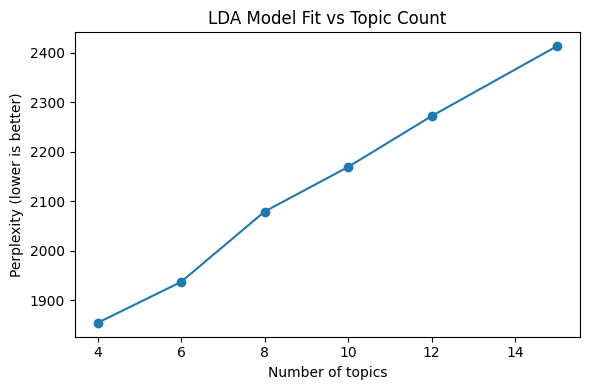

,topic_id,top_words
0,Topic 0,"dog, one, not, hot, hot dog, get, no, see, love, pizza, eat, run"
1,Topic 1,"go, go costco, store, shop, kid, spot, not, find, sam, even, food, trader"
2,Topic 2,"get, not, card, lot, go, make, food, look, chicken, parking, day, parking lot"
3,Topic 3,"sam, club, get, sam club, not, xbox, store, walmart, no, costco sam, product, go"
4,Topic 4,"membership, gold, buy, cost, stock, get, need, price, go, not, sale, sell"
5,Topic 5,"buy, get, good, one, sell, make, beef, price, guy, go, cheap, know"


In [37]:
# === Show results after the training loop ===
from IPython.display import display
import matplotlib.pyplot as plt

# 1) Check we actually collected results
if "scores" not in globals() or scores.empty:
    raise RuntimeError("No results recorded. Make sure you ran the training loop that fills `scores` and `topic_summaries`.")

# 2) Show the scores table
display(scores.sort_values("n_topics"))

# 3) Plot perplexity vs #topics
plt.figure(figsize=(6,4))
plt.plot(scores["n_topics"], scores["perplexity"], marker="o")
plt.xlabel("Number of topics")
plt.ylabel("Perplexity (lower is better)")
plt.title("LDA Model Fit vs Topic Count")
plt.tight_layout()
plt.show()

# 4) Show the top words for a chosen topic count (change n as you like)
n = 6
have = sorted(topic_summaries.keys())
if n in topic_summaries:
    display(topic_summaries[n])
else:
    print(f"Requested n={n}, but available topic counts are: {have}")


## LDA

In [38]:
# --- Sentiment splits & stopword policy setup (run before the LDA block) ---

# 1) Basic guard
assert "rob_label" in prep.columns, "prep needs a 'rob_label' column."

# 2) Split per sentiment (fresh RangeIndex for stability)
pos_prep = prep.loc[prep["rob_label"].eq("positive")].copy().reset_index(drop=True)
neg_prep = prep.loc[prep["rob_label"].eq("negative")].copy().reset_index(drop=True)
# Optional:
# neu_prep = prep.loc[prep["rob_label"].eq("neutral")].copy().reset_index(drop=True)

assert len(pos_prep) > 0, "No positive rows found in prep."
assert len(neg_prep) > 0, "No negative rows found in prep."

# 3) Ensure global stopword policy is defined upstream (single source of truth)
if "stop_set" not in globals():
    raise RuntimeError(
        "stop_set not found. Run the stopword policy cell (where DOMAIN_STOPS is defined) first."
    )

# 4) Choose ONE common text column for BOTH pos/neg (prevents mismatched preprocessing)
COMMON_TEXT_PRIORITY = [
    "clean_nostop",   # preferred: already stop-removed
    "clean_lemmas",
    "clean",
    "no_stop",        # list of tokens
    "lemmas",         # list of tokens
    "tokens"          # list of tokens
]

common_col = next(
    (c for c in COMMON_TEXT_PRIORITY if c in pos_prep.columns and c in neg_prep.columns),
    None
)
if common_col is None:
    raise ValueError(f"No common text column across pos/neg from {COMMON_TEXT_PRIORITY}.")

pos_text_col = neg_text_col = common_col

# 5) Vectorizer stopword decision (avoid double removal if using clean_nostop)
use_vec_stopwords = (pos_text_col != "clean_nostop")  # same for both now
vec_stop_words = stop_set if use_vec_stopwords else None

# 6) Quick sanity checks (non-empty strings after stripping)
_pos_nonempty = pos_prep[pos_text_col].astype(str).str.strip().str.len().gt(0).any()
_neg_nonempty = neg_prep[neg_text_col].astype(str).str.strip().str.len().gt(0).any()
assert _pos_nonempty and _neg_nonempty, f"Chosen column '{pos_text_col}' appears empty on one split."

# 7) Debug summary
print({
    "pos_rows": len(pos_prep),
    "neg_rows": len(neg_prep),
    "text_col": pos_text_col,  # same for both
    "vectorizer_stopwords": "stop_set" if vec_stop_words is not None else "None (already no-stop)"
})


{'pos_rows': 3417, 'neg_rows': 3666, 'text_col': 'clean_nostop', 'vectorizer_stopwords': 'None (already no-stop)'}


In [39]:

# ---------- helper: make short labels that favor bigrams ----------
def make_topic_label(top_terms, n_words=4):
    # prefer bigrams first if available
    bigrams = [w for w in top_terms if " " in w]
    if bigrams:
        keep = bigrams[:min(len(bigrams), n_words)]
        if len(keep) < n_words:
            uni = [w for w in top_terms if " " not in w and w not in keep]
            keep += uni[:(n_words - len(keep))]
    else:
        keep = top_terms[:n_words]
    return " · ".join(keep)

# ---------- core: build per-topic exemplars and concise labels ----------
def summarize_topics_with_exemplars(
    doc_topic: np.ndarray,
    topic_term: np.ndarray,
    vocab_lda: np.ndarray,
    corpus,                         # pandas Series or list/array of texts in the SAME ORDER as doc_topic rows
    sentiments=None,                # optional 1D array/list aligned to doc_topic rows (e.g., ["pos", ...,"neg"])
    meta: pd.DataFrame | None = None,  # optional extra columns aligned by position (length == n_docs)
    n_top_words: int = 10,
    exemplars_per_topic: int = 3,
    min_prop: float = 0.10,         # only consider docs where topic proportion >= min_prop
    preview_len: int = 160
):
    # --- Make a stable, positional corpus df: doc_idx matches row in doc_topic ---
    if isinstance(corpus, pd.Series):
        corpus_values = corpus.values
    else:
        corpus_values = np.asarray(list(corpus))
    n_docs = len(corpus_values)
    assert doc_topic.shape[0] == n_docs, "doc_topic rows must equal corpus length"

    corpus_df = pd.DataFrame({
        "doc_idx": np.arange(n_docs, dtype=int),
        "text": corpus_values.astype(str)
    })

    # attach sentiments if provided
    if sentiments is not None:
        sentiments = list(sentiments)
        assert len(sentiments) == n_docs, "len(sentiments) must equal corpus length"
        corpus_df["sentiment"] = sentiments

    # attach extra meta columns if provided (positional)
    if meta is not None:
        assert len(meta) == n_docs, "meta must have same length as corpus"
        meta_reset = meta.reset_index(drop=True).copy()
        meta_reset.insert(0, "doc_idx", np.arange(n_docs, dtype=int))
        corpus_df = corpus_df.merge(meta_reset, on="doc_idx", how="left")

    # --- Top words per topic (by component weight) ---
    K = topic_term.shape[0]
    top_idx = np.argsort(topic_term, axis=1)[:, ::-1][:, :n_top_words]
    top_words = [[str(vocab_lda[j]) for j in top_idx[k]] for k in range(K)]

    # --- Long-form exemplars (top documents for each topic) ---
    rows = []
    for k in range(K):
        scores = doc_topic[:, k]
        eligible = np.where(scores >= min_prop)[0]
        # take the highest-scoring documents for this topic
        if eligible.size:
            take = eligible[np.argsort(scores[eligible])[::-1]][:exemplars_per_topic]
            for r, di in enumerate(take, start=1):
                rows.append({
                    "topic": k,
                    "rank": r,
                    "score": float(scores[di]),
                    "doc_idx": int(di),
                })
    exemplars_long = pd.DataFrame(rows)

    # attach text + previews (+ any optional meta columns already in corpus_df)
    if not exemplars_long.empty:
        exemplars_long = (
            exemplars_long
            .merge(corpus_df, on="doc_idx", how="left")
            .rename(columns={"text": "exemplar_text"})
        )
        exemplars_long["preview"] = exemplars_long["exemplar_text"].astype(str).str.slice(0, preview_len)

    # --- Per-topic compact summary (label + top words + up to 3 previews) ---
    summaries = []
    for k in range(K):
        label = make_topic_label(top_words[k], n_words=4)
        topk = exemplars_long.loc[exemplars_long["topic"] == k].sort_values("rank")
        previews = topk["preview"].tolist() if not topk.empty else []
        summaries.append({
            "topic": k,
            "label": label,
            "top_words": ", ".join(top_words[k]),
            "exemplar_1": previews[0] if len(previews) > 0 else "",
            "exemplar_2": previews[1] if len(previews) > 1 else "",
            "exemplar_3": previews[2] if len(previews) > 2 else "",
        })

    topic_summaries_df = pd.DataFrame(summaries)
    topic_exemplars_df = exemplars_long.sort_values(["topic", "rank"]).reset_index(drop=True)
    return topic_summaries_df, topic_exemplars_df


In [40]:
# Reuse grid-search outputs safely, just alias the names:
count_vec_shared   = vectorizer_lda
X_shared_counts    = X_for_lda
vocab_topics       = vocab_lda


Top words per topic (shared across pos & neg):


,topic_id,top_words
0,Topic 0,"dog, not, no, hot, hot dog, pizza, great, one, eat, even, costco hot, make"
1,Topic 1,"go, go costco, kid, would, take, trader, need, food, joe, trader joe, shop, never"
2,Topic 2,"price, not, chicken, go, gold, egg, new, food, still, come, look, rotisserie"
3,Topic 3,"sam, club, store, sam club, not, shop, costco sam, xbox, walmart, grocery, shopping, gas"
4,Topic 4,"membership, buy, gold, go, not, get, costco membership, bar, need, go costco, sell, know"
5,Topic 5,"buy, get, sell, one, good, price, beef, meat, make, best, protein, guy"
6,Topic 6,"get, one, sample, run, costco get, see, go, free, get costco, cheap, back, make"
7,Topic 7,"sale, cost, good, stock, one, retail, really, strong, share, get, growth, market"
8,Topic 8,"lot, parking, card, spot, get, hotdog, parking lot, park, love, car, costco parking, minute"
9,Topic 9,"get, last, good, bag, box, make, pumpkin, week, buy, pie, pretty, one"



Overall topic prevalence (combined corpus):


,topic_id,prevalence
0,Topic 5,0.123075
1,Topic 1,0.115112
2,Topic 0,0.108932
3,Topic 6,0.102469
4,Topic 4,0.098342
5,Topic 9,0.096717
6,Topic 8,0.094074
7,Topic 3,0.090615
8,Topic 2,0.088422
9,Topic 7,0.082241



Average topic mixture by sentiment:


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
sentiment,,,,,,,,,,
neg,0.107125,0.129338,0.097965,0.108898,0.104417,0.132367,0.093257,0.064548,0.090334,0.071750
pos,0.110872,0.099850,0.078184,0.070998,0.091823,0.113105,0.112353,0.101224,0.098087,0.123503


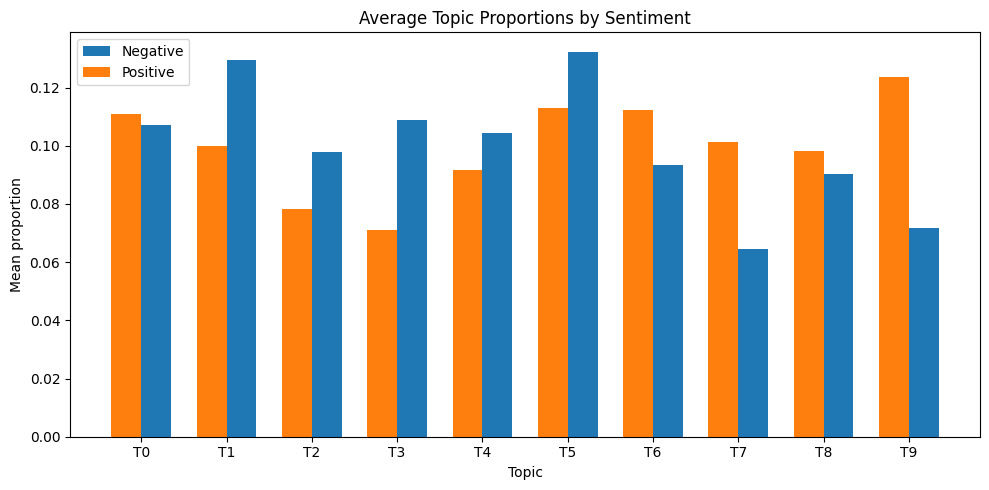

In [41]:
# Test LDA on 2 dfs now — shared topics for pos vs neg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from IPython.display import display

# ------------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------------
N_TOPICS     = 10
N_TOP_WORDS  = 12
RANDOM_STATE = 0

assert "pos_prep" in globals() and "neg_prep" in globals(), "Run the sentiment-split setup cell first."
assert len(pos_prep) > 0 and len(neg_prep) > 0, "Empty pos/neg splits."

# ------------------------------------------------------------------
# Choose text source (prefer already stop-removed, lemmatized text)
# ------------------------------------------------------------------
TEXT_PRIORITY = [
    "clean_nostop",
    "clean_lemmas",
    "clean",
    "no_stop",
    "lemmas",
    "tokens",
]

def choose_text_col(df: pd.DataFrame) -> str:
    for c in TEXT_PRIORITY:
        if c in df.columns:
            return c
    raise ValueError(f"None of expected text columns {TEXT_PRIORITY} in: {list(df.columns)}")

def to_text(series: pd.Series, colname: str) -> pd.Series:
    if colname in {"no_stop", "lemmas", "tokens"}:
        return series.apply(lambda x: " ".join(x) if isinstance(x, (list, tuple)) else str(x))
    return series.astype(str)

pos_text_col = choose_text_col(pos_prep)
neg_text_col = choose_text_col(neg_prep)

pos_corp = to_text(pos_prep[pos_text_col], pos_text_col).str.strip()
neg_corp = to_text(neg_prep[neg_text_col], neg_text_col).str.strip()

# keep non-empty rows
pos_corp = pos_corp[pos_corp.str.len() > 0].reset_index(drop=True)
neg_corp = neg_corp[neg_corp.str.len() > 0].reset_index(drop=True)

# combined corpus for shared vocab/topics — force a fresh RangeIndex
corp = pd.concat([pos_corp, neg_corp], axis=0, ignore_index=True)

# sentiment labels by position (length matches corp exactly)
sent_labels = pd.Series(
    np.r_[np.full(len(pos_corp), "pos"), np.full(len(neg_corp), "neg")],
    index=corp.index
)

# ------------------------------------------------------------------
# Stopword policy — use the single global stop_set defined earlier
# Avoid double-removal if already using clean_nostop
# ------------------------------------------------------------------
assert "stop_set" in globals(), "stop_set not found. Run the stopword policy cell first."
vec_stop_words = None if (pos_text_col == "clean_nostop" and neg_text_col == "clean_nostop") else stop_set

# ------------------------------------------------------------------
# Fit LDA (batch for final model)
# ------------------------------------------------------------------
X_corp = count_vec_shared.transform(corp)
lda = LatentDirichletAllocation(
    n_components=N_TOPICS,
    learning_method="batch",
    random_state=RANDOM_STATE
)
doc_topic = lda.fit_transform(X_corp)     # (n_docs, n_topics)
topic_term = lda.components_         # (n_topics, n_terms)

# ------------------------------------------------------------------
# Top words per topic
# ------------------------------------------------------------------
def top_words_for_topic(k, n_words=N_TOP_WORDS):
    idx = np.argsort(topic_term[k])[::-1][:n_words]
    return ", ".join(vocab_topics[idx])

topics_table = pd.DataFrame({
    "topic_id": [f"Topic {k}" for k in range(N_TOPICS)],
    "top_words": [top_words_for_topic(k, N_TOP_WORDS) for k in range(N_TOPICS)]
})

# ------------------------------------------------------------------
# Per-document mixtures & dominant topic (index matches corp RangeIndex)
# ------------------------------------------------------------------
doc_topic_df = pd.DataFrame(doc_topic, columns=[f"Topic_{k}" for k in range(N_TOPICS)])
doc_topic_df["dominant_topic"] = doc_topic_df.values.argmax(axis=1)
doc_topic_df["sentiment"] = sent_labels.values
doc_topic_df["text_preview"] = corp.str.slice(0, 160).values

# ------------------------------------------------------------------
# Topic prevalence overall & by sentiment
# ------------------------------------------------------------------
overall_prev = doc_topic.sum(axis=0)
overall_prev = overall_prev / overall_prev.sum()

by_sent = (
    doc_topic_df
    .groupby("sentiment")[[f"Topic_{k}" for k in range(N_TOPICS)]]
    .mean()
)

plot_df = by_sent.T.reset_index(drop=True)

# ------------------------------------------------------------------
# (Optional) attach topic proportions back to pos_prep / neg_prep copies
# ------------------------------------------------------------------
pos_topics = pos_prep.copy()
neg_topics = neg_prep.copy()

n_pos = len(pos_corp)
# Slice by position: first n_pos rows are pos, remaining are neg
for k in range(N_TOPICS):
    pos_topics[f"Topic_{k}"] = np.nan
    neg_topics[f"Topic_{k}"] = np.nan
    pos_topics.loc[:, f"Topic_{k}"] = doc_topic_df.iloc[:n_pos, k].values
    neg_topics.loc[:, f"Topic_{k}"] = doc_topic_df.iloc[n_pos:, k].values

pos_topics["dominant_topic"] = doc_topic_df.iloc[:n_pos]["dominant_topic"].values
neg_topics["dominant_topic"] = doc_topic_df.iloc[n_pos:]["dominant_topic"].values

# ------------------------------------------------------------------
# Displays
# ------------------------------------------------------------------
pd.set_option("display.max_colwidth", None)
print("Top words per topic (shared across pos & neg):")
display(topics_table)
pd.set_option("display.max_colwidth", 50)

print("\nOverall topic prevalence (combined corpus):")
display(pd.DataFrame({
    "topic_id": [f"Topic {k}" for k in range(N_TOPICS)],
    "prevalence": overall_prev
}).sort_values("prevalence", ascending=False).reset_index(drop=True))

print("\nAverage topic mixture by sentiment:")
display(by_sent)

#Fix colors
neg_color = "#1f77b4"
pos_color = "#ff7f0e"

# Quick comparison chart: pos vs neg per topic
plt.figure(figsize=(10, 5))
x = np.arange(N_TOPICS)
width = 0.35
plt.bar(x + width/2, plot_df["neg"].values, width, label="Negative", color = neg_color)
plt.bar(x - width/2, plot_df["pos"].values, width, label="Positive", color = pos_color)
plt.xticks(x, [f"T{k}" for k in range(N_TOPICS)])
plt.title("Average Topic Proportions by Sentiment")
plt.xlabel("Topic")
plt.ylabel("Mean proportion")
plt.legend()
plt.tight_layout()
plt.show()


## Index Verification

This checks-
- Same number of rows across corp, X, doc_topic, and doc_topic_df.
- The first n_pos documents are labeled “pos” and the rest “neg”.
- text_preview is actually sliced from corp.
- (If used) pos_topics/neg_topics match original split lengths.
- Random spot checks ensure corp rows equal the corresponding pos_corp/neg_corp rows.
- LDA mixtures per document sum to ~1.0.

In [42]:
# ---------------- Alignment / Sanity Audit ----------------
import hashlib

def _md5_series(s: pd.Series) -> str:
    # stable checksum for a text series
    h = hashlib.md5()
    for x in s.astype(str).values:
        h.update(x.encode("utf-8", errors="ignore"))
    return h.hexdigest()

problems = []

# 1) Basic shapes
try:
    assert len(corp) == X_corp.shape[0] == doc_topic.shape[0] == len(doc_topic_df), \
        f"Row mismatch: corp={len(corp)}, X_corp={X_corp.shape[0]}, doc_topic={doc_topic.shape[0]}, doc_topic_df={len(doc_topic_df)}"
except AssertionError as e:
    problems.append(str(e))

# 2) Sentiment labels align 1:1 with corp
try:
    assert (sent_labels.index == corp.index).all(), "sent_labels index != corp index"
    assert len(sent_labels) == len(corp), "sent_labels length mismatch"
except AssertionError as e:
    problems.append(str(e))

# 3) Pos/Neg split by position is consistent
n_pos = len(pos_corp)
n_neg = len(neg_corp)
try:
    assert n_pos + n_neg == len(corp), "pos_corp + neg_corp length != corp length"
    assert (sent_labels.iloc[:n_pos] == "pos").all(), "First n_pos labels are not all 'pos'"
    assert (sent_labels.iloc[n_pos:] == "neg").all(), "Last n_neg labels are not all 'neg'"
except AssertionError as e:
    problems.append(str(e))

# 4) doc_topic_df’s first/last segments match pos/neg counts
try:
    assert doc_topic_df.iloc[:n_pos].shape[0] == n_pos, "doc_topic_df[:n_pos] size mismatch"
    assert doc_topic_df.iloc[n_pos:].shape[0] == n_neg, "doc_topic_df[n_pos:] size mismatch"
except AssertionError as e:
    problems.append(str(e))

# 5) Check that text_preview came from corp (spot & hash)
try:
    preview_hash = _md5_series(doc_topic_df["text_preview"].fillna(""))
    corp_hash    = _md5_series(corp.str.slice(0, 160).fillna(""))
    assert preview_hash == corp_hash, "text_preview does not hash-match corp.slice(0,160)"
except AssertionError as e:
    problems.append(str(e))

# 6) If you attached back to pos_topics/neg_topics, confirm lengths and NaNs
if "pos_topics" in globals() and "neg_topics" in globals():
    try:
        assert len(pos_topics) == len(pos_prep), "pos_topics length != pos_prep length"
        assert len(neg_topics) == len(neg_prep), "neg_topics length != neg_prep length"
    except AssertionError as e:
        problems.append(str(e))
    # optional: check a couple of topic columns exist and have no all-NaN
    sample_cols = [c for c in pos_topics.columns if c.startswith("Topic_")][:3]
    for c in sample_cols:
        if pos_topics[c].isna().all() or neg_topics[c].isna().all():
            problems.append(f"Column {c} is all-NaN in one of pos_topics/neg_topics")

# 7) Random spot checks: a few rows must agree exactly with slices
rng = np.random.default_rng(7)
if len(corp) >= 5:
    idxs = rng.choice(len(corp), size=min(5, len(corp)), replace=False)
    for i in idxs:
        if i < n_pos:
            a = corp.iloc[i]
            b = pos_corp.iloc[i]
            if str(a).strip() != str(b).strip():
                problems.append(f"Spot-check mismatch at i={i}: corp vs pos_corp")
        else:
            j = i - n_pos
            a = corp.iloc[i]
            b = neg_corp.iloc[j]
            if str(a).strip() != str(b).strip():
                problems.append(f"Spot-check mismatch at i={i} (j={j}): corp vs neg_corp")

# 8) Topic matrix sanity: rows sum ~ 1 (within tolerance)
row_sums = doc_topic.sum(axis=1)
if not np.allclose(row_sums, 1.0, atol=1e-3):
    problems.append("Some doc_topic rows do not sum close to 1.")

# 9) Report
if problems:
    print("❌ Alignment checks found issues:")
    for p in problems:
        print(" -", p)
else:
    print("✅ Alignment looks good (indices, labels, corp/doc_topic, and previews match).")

# Helpful mini-summary
print("\nCounts:", {"pos_docs": int(n_pos), "neg_docs": int(n_neg), "total": int(len(corp))})
print("Example labels head:", sent_labels.head(3).tolist(), "… tail:", sent_labels.tail(3).tolist())


✅ Alignment looks good (indices, labels, corp/doc_topic, and previews match).

Counts: {'pos_docs': 3417, 'neg_docs': 3666, 'total': 7083}
Example labels head: ['pos', 'pos', 'pos'] … tail: ['neg', 'neg', 'neg']


## Topic Summaries and Exemplar Tweets

In [43]:
topic_term = lda.components_

assert doc_topic.shape[0] == len(corp), "doc_topic rows must match corpus length"
assert len(corp) == len(pos_corp) + len(neg_corp), "corp order/length mismatch"
assert doc_topic.shape[1] == topic_term.shape[0], "doc_topic topics != topic_term rows"
assert topic_term.shape[1] == len(vocab_topics), "topic_term terms != vocab_topics length"

n_pos, n_neg = len(pos_corp), len(neg_corp)

topic_summaries_df, topic_exemplars_df = summarize_topics_with_exemplars(
    doc_topic=doc_topic,
    topic_term=topic_term,
    vocab_lda=vocab_topics,
    corpus=corp,
    sentiments=sent_labels.tolist(),      # optional but nice
    n_top_words=12,
    exemplars_per_topic=3,
    min_prop=0.15,
    preview_len=160
)

from IPython.display import display
display(topic_summaries_df.head(10))
display(topic_exemplars_df.head(6))


,topic,label,top_words,exemplar_1,exemplar_2,exemplar_3
0,0,hot dog · costco hot · dog · not,"dog, not, no, hot, hot dog, pizza, great, one,...",northern chicago area hour not see single muzz...,suspect play love wife act surprised announcem...,guess next gonna eat costco hot dog chicken ba...
1,1,go costco · trader joe · go · kid,"go, go costco, kid, would, take, trader, need,...",junk food get basic food cook clean healthy me...,make financial sense shop father trader joe's ...,reading glass costco receipt miss keep ny vehi...
2,2,price · not · chicken · go,"price, not, chicken, go, gold, egg, new, food,...",not disagree argument generalise stuff costco ...,death threat not protect yet someone attack fa...,vote use power dollar trip abroad come home pe...
3,3,sam club · costco sam · sam · club,"sam, club, store, sam club, not, shop, costco ...",major retailer pull xbox console shelf costco ...,next xbox not happen already see sam club cost...,next no personal shopping trip costco load car...
4,4,costco membership · go costco · membership · buy,"membership, buy, gold, go, not, get, costco me...",duracell seem kodak moment life cycle buy anot...,may head costco stock pantry staple supply kno...,may head costco stock pantry staple supply kno...
5,5,buy · get · sell · one,"buy, get, sell, one, good, price, beef, meat, ...",costco midwest sell halal meat inhumane need b...,toss protein costco grass feed protein site je...,american buy box soda costco kid cut label fin...
6,6,costco get · get costco · get · one,"get, one, sample, run, costco get, see, go, fr...",completely slip past mind happy birthday ya ke...,yes ckd fluid every day special food high bloo...,cool look great handle costco run gear weekend...
7,7,sale · cost · good · stock,"sale, cost, good, stock, one, retail, really, ...",costco wholesale corp wednesday notch sale gai...,costco stock climb bell here's cost share rise...,costco cost costco wholesale sale climb septem...
8,8,parking lot · costco parking · lot · parking,"lot, parking, card, spot, get, hotdog, parking...",usaa cancel credit card night leave trip night...,must extraordinarily busy costco never look mi...,amazing thing somehow immediately recognize co...
9,9,get · last · good · bag,"get, last, good, bag, box, make, pumpkin, week...",giveaway day value prize 8x bbwf bundle 2x blo...,help spread word prize grab prize include 8x b...,pay stove top coffee pot pay massive tin costc...


,topic,rank,score,doc_idx,exemplar_text,sentiment,preview
0,0,1,0.981245,4544,northern chicago area hour not see single muzz...,neg,northern chicago area hour not see single muzz...
1,0,2,0.967847,3468,suspect play love wife act surprised announcem...,neg,suspect play love wife act surprised announcem...
2,0,3,0.963996,3621,guess next gonna eat costco hot dog chicken ba...,neg,guess next gonna eat costco hot dog chicken ba...
3,1,1,0.963994,4138,junk food get basic food cook clean healthy me...,neg,junk food get basic food cook clean healthy me...
4,1,2,0.962494,3684,make financial sense shop father trader joe's ...,neg,make financial sense shop father trader joe's ...
5,1,3,0.960860,4049,reading glass costco receipt miss keep ny vehi...,neg,reading glass costco receipt miss keep ny vehi...


## Visualize Topics Interactively pyLDAvis

In [44]:
# %pip install pyLDAvis  # uncomment if you haven't installed it

import os, warnings
import numpy as np
import pyLDAvis
import transformers
from pathlib import Path
from IPython.display import display

# ---------- pick helper: fetch by name to avoid boolean coercion ----------
def pick(*names):
    for n in names:
        if n in globals() and globals()[n] is not None:
            return globals()[n]
    return None

# --------- Suppress messages in stdout -----------
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore", category=UserWarning)
transformers.logging.set_verbosity_error()

# ---- resolve your objects without using `or` on arrays/sparse ----
lda_model        = pick("lda", "lda_model")
count_matrix     = pick("X_shared_counts", "X", "X_lda")
count_vectorizer = pick("count_vec_shared", "vectorizer", "vectorizer_lda")

assert lda_model is not None,        "Missing trained LDA model (e.g., `lda`)."
assert count_matrix is not None,     "Missing document-term COUNT matrix (e.g., `X`)."
assert count_vectorizer is not None, "Missing CountVectorizer (e.g., `vectorizer`)."

# Sanity: feature alignment
vocab = np.array(count_vectorizer.get_feature_names_out())
assert count_matrix.shape[1] == len(vocab), "Counts columns != vocab size."

# ---- try sklearn shim first; else manual prepare (works on all versions) ----
try:
    from pyLDAvis import sklearn as sklearn_lda
    pyLDAvis.enable_notebook()
    vis = sklearn_lda.prepare(lda_model, count_matrix, count_vectorizer, mds="pcoa")
except Exception:
    pyLDAvis.enable_notebook()

    term_frequency = np.asarray(count_matrix.sum(axis=0)).ravel().astype(float)
    doc_lengths    = np.asarray(count_matrix.sum(axis=1)).ravel().astype(float)

    # Topic-term distributions (K x V)
    topic_term = lda_model.components_.astype(float)
    topic_term_dists = topic_term / (topic_term.sum(axis=1, keepdims=True) + 1e-12)

    # Doc-topic distributions (D x K)
    doc_topic = lda_model.transform(count_matrix).astype(float)
    doc_topic_dists = doc_topic / (doc_topic.sum(axis=1, keepdims=True) + 1e-12)

    vis = pyLDAvis.prepare(
        topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency,
        mds="pcoa", sort_topics=False
    )

display(vis)

# Save a shareable HTML next to your exports
outdir = Path(f"Checkpoints")
outdir.mkdir(parents=True, exist_ok=True)
html_path = outdir / f"{topic}_pyldavis.html"


with open(html_path, "w", encoding="utf-8") as f:
    pyLDAvis.save_html(vis, f)

print("Saved:", html_path.resolve())

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.027404 -0.033029       1        1  10.088431
1      0.139391 -0.075405       2        1   9.938499
2     -0.060109 -0.069740       3        1   9.792587
3     -0.023509 -0.131415       4        1  10.418275
4     -0.022549 -0.096386       5        1  10.935824
5      0.037580 -0.024434       6        1  12.543197
6      0.064198  0.055162       7        1   9.407757
7     -0.249317  0.111115       8        1   9.471981
8      0.121000  0.197028       9        1   8.443678
9      0.020719  0.067104      10        1   8.959770, topic_info=           Term         Freq        Total Category  logprob  loglift
1270         go  1920.000000  1920.000000  Default  30.0000  30.0000
1274  go costco   668.000000   668.000000  Default  29.0000  29.0000
2423        sam   491.000000   491.000000  Default  28.0000  28.0000
2416       sale   422.000000   422.000000  Default  27.0000  27.0000
327         buy  1360.000000  1360.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1408       home    65.335761   263.248839  Topic10  -5.3172   1.0189
2744       take    69.589034   462.986116  Topic10  -5.2541   0.5173
425     chicken    68.468442   414.496346  Topic10  -5.2703   0.6117
1945        not    71.072394  1541.466247  Topic10  -5.2330  -0.6644
215         big    59.594745   346.783355  Topic10  -5.4091   0.6513

[695 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
19        8  0.891270    account
19        9  0.074272    account
25        2  0.015856         ad
25        5  0.713508         ad
25        6  0.063423         ad
...     ...       ...        ...
3094     10  0.181332  yesterday
3098      6  0.896808     yogurt
3098     10  0.059787     yogurt
3099      1  0.872599       york
3103      8  0.964323        yoy

[1736 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

Saved: /Users/thomas/Documents/Projects/X Sentiment/Costco/Costco Domain/Checkpoints/costco_d_pyldavis.html


**pyLDAvis - Relevance Metric**

| λ value              | Emphasis                      | What you’ll see                                                                                                       |
|----------------------|-------------------------------|------------------------------------------------------------------------------------------------------------------------|
| **λ = 1.0**          | Highest probability terms      | Common words within that topic, possibly shared across topics                    |
| **λ = 0.0**          | Most exclusive / distinctive terms | Words that are unusually characteristic of this topic but maybe rarer overall |
| **λ ≈ 0.6 (default)** | Balanced                      | Mix of high-frequency and topic-specific words—this setting often gives the most interpretable results                 |

## Coherence Scores (c_v, u_mass, c_npmi)
Tune number of topics to improve interpretability at elbow point

# Automatic Interpretation of Topic Results WIP

## Export Topic Summary & Exemplars, and IDF Metrics for LLM Distillation

In [45]:
# === LLM JSONL exports with {topic} in folder, filenames, and records ===
import json, math, re, time, unicodedata
from pathlib import Path
import numpy as np
import pandas as pd

OUTDIR = Path(f"Checkpoints")
OUTDIR.mkdir(parents=True, exist_ok=True)

def _clean(s, maxlen=None):
    s = "" if pd.isna(s) else re.sub(r"\s+", " ", str(s)).strip()
    return s[:maxlen] if maxlen and len(s) > maxlen else s

def _f(x):
    try:
        v = float(x)
        return v if np.isfinite(v) else 0.0
    except Exception:
        return 0.0

def write_jsonl(path: Path, records):
    with path.open("w", encoding="utf-8") as f:
        for r in records:
            json.dump(r, f, ensure_ascii=False)
            f.write("\n")

# -----------------------
# 1) Polarity terms JSONL
# -----------------------
if "tidy" not in globals():
    raise RuntimeError("`tidy` not found (need sentiment/term/agg/iwdf).")

pol = tidy.copy()
need = {"sentiment","term","agg","iwdf"}
missing = need - set(pol.columns)
if missing:
    raise RuntimeError(f"`tidy` missing columns: {sorted(missing)}")

for col in ("agg","iwdf"):
    pol[col] = pol[col].map(_f)

def _mm(g, c):
    return (g[c] - g[c].min()) / (g[c].max() - g[c].min() + 1e-12)

if "agg_norm" not in pol.columns:
    pol["agg_norm"]  = pol.groupby("sentiment")["agg"] .transform(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-12))
if "iwdf_norm" not in pol.columns:
    pol["iwdf_norm"] = pol.groupby("sentiment")["iwdf"].transform(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-12))

pol["term"] = pol["term"].map(lambda x: _clean(x, 120))
pol = pol.loc[pol["term"].ne("")]

polarity_jsonl = OUTDIR / f"{topic}_polar_terms.jsonl"
write_jsonl(polarity_jsonl, [
    {
        "topic": topic,  # <-- string tag you asked for
        "sentiment": r["sentiment"],
        "term": r["term"],
        "scores": {
            "agg": float(r["agg"]),
            "iwdf": float(r["iwdf"]),
            "agg_norm": float(r["agg_norm"]),
            "iwdf_norm": float(r["iwdf_norm"]),
        }
    }
    for _, r in pol.sort_values(
        ["sentiment","agg_norm","iwdf_norm"], ascending=[True, False, False]
    ).iterrows()
])

# --------------------------------
# 2) Topic summaries + exemplars
# --------------------------------
if "topic_summaries_df" not in globals() or "topic_exemplars_df" not in globals():
    raise RuntimeError("Need `topic_summaries_df` and `topic_exemplars_df` to export topics.")

ts = topic_summaries_df.copy()
te = topic_exemplars_df.copy()

ts["topic"] = ts["topic"].astype(int)
ts["label"] = ts["label"].map(lambda s: _clean(s, 120))
ts["top_words"] = ts["top_words"].map(lambda s: _clean(s, 500))
for c in [c for c in ts.columns if c.startswith("exemplar_")]:
    ts[c] = ts[c].map(lambda s: _clean(s, 300))

te["topic"] = te["topic"].astype(int)
if "rank" in te: te["rank"] = te["rank"].astype(int)
if "score" in te: te["score"] = te["score"].map(_f)
if "preview" in te: te["preview"] = te["preview"].map(lambda s: _clean(s, 300))
if "exemplar_text" in te: te["exemplar_text"] = te["exemplar_text"].map(lambda s: _clean(s, 4000))
if "sentiment" in te: te["sentiment"] = te["sentiment"].map(lambda s: _clean(s, 24))

# Summaries JSONL (note: use topic_id to avoid colliding with string topic tag)
summ_jsonl = OUTDIR / f"{topic}_summary.jsonl"
write_jsonl(summ_jsonl, [
    {
        "topic": topic,            # string tag
        "topic_id": int(r["topic"]),
        "label": r["label"],
        "top_words": r["top_words"],
        "exemplars": [r.get("exemplar_1",""), r.get("exemplar_2",""), r.get("exemplar_3","")]
    }
    for _, r in ts.sort_values("topic").iterrows()
])

# Exemplars JSONL
exem_jsonl = OUTDIR / f"{topic}_exemplars.jsonl"
write_jsonl(exem_jsonl, [
    {
        "topic": topic,            # string tag
        "topic_id": int(r["topic"]),
        **({"rank": int(r["rank"])} if "rank" in te.columns else {}),
        **({"score": float(r["score"])} if "score" in te.columns else {}),
        **({"doc_idx": int(r["doc_idx"])} if "doc_idx" in te.columns else {}),
        **({"sentiment": r["sentiment"]} if "sentiment" in te.columns else {}),
        **({"preview": r["preview"]} if "preview" in te.columns else {}),
    }
    for _, r in te.sort_values(["topic","rank"] if "rank" in te.columns else ["topic"]).iterrows()
])

print(f"✓ Wrote {polarity_jsonl.name}")
print(f"✓ Wrote {summ_jsonl.name}")
print(f"✓ Wrote {exem_jsonl.name}")
print("→ Folder:", OUTDIR.resolve())

import warnings
warnings.simplefilter("always")


✓ Wrote costco_d_polar_terms.jsonl
✓ Wrote costco_d_summary.jsonl
✓ Wrote costco_d_exemplars.jsonl
→ Folder: /Users/thomas/Documents/Projects/X Sentiment/Costco/Costco Domain/Checkpoints


## LLM Prompt

In [46]:
SYSTEM_PROMPT = """You are an analyst. You receive three JSONL files that describe a topic’s language landscape. 
They are already precomputed (no need to recalc anything). Use them to produce crisp insights,
explanations, and evidence.

FILES & SCHEMAS

1) {topic}_polar_terms.jsonl
   One record per (sentiment, term).
   {
     "topic": "<string topic tag>",
     "sentiment": "negative" | "neutral" | "positive",
     "term": "<ngram>",
     "scores": {
       "agg": <float>,          // aggregate prominence: sum of raw TF–IDF across docs with that sentiment
       "iwdf": <float>,         // coverage × distinctiveness: (subset document frequency) × idf
       "agg_norm": <float>,     // min–max normalized within sentiment (0–1)
       "iwdf_norm": <float>     // min–max normalized within sentiment (0–1)
     }
   }

   Interpretation:
   - High agg_norm ⇒ term is broadly prominent within that sentiment.
   - High iwdf_norm ⇒ term is distinctive (appears in many docs of that sentiment and carries idf).
   - A good “standout” term balances both (e.g., harmonic mean or simple average of agg_norm & iwdf_norm).

2) {topic}_summary.jsonl
   One record per topic_id.
   {
     "topic": "<string topic tag>",
     "topic_id": <int>,
     "label": "<short label preferring bigrams>",
     "top_words": "<comma-separated top words>",
     "exemplars": ["<preview1>", "<preview2>", "<preview3>"]
   }

   Interpretation:
   - topic_id is an integer index over a shared vocabulary (topics trained jointly).
   - label is a compact human-readable tag; top_words are the ranked terms.
   - exemplars are short document snippets most representative of the topic.

3) {topic}_exemplars.jsonl
   Many rows; top documents per topic.
   {
     "topic": "<string topic tag>",
     "topic_id": <int>,
     "rank": <int>,     // 1 = best doc for that topic (if provided)
     "score": <float>,  // topic proportion (if provided)
     "doc_idx": <int>,  // positional index into the modeling corpus (if provided)
     "sentiment": "<optional sentiment label>",
     "preview": "<short text preview>"
   }

   Interpretation:
   - Use these when you need more supporting evidence beyond the 3 previews provided in the summaries.
   - Prefer higher rank / higher score exemplars as primary evidence.

GENERAL REASONING GUIDELINES

- When ranking “standout” terms per sentiment, combine agg_norm and iwdf_norm (simple average is fine).
- Use topic_summaries for conceptual framing (labels + top_words), then pull evidence (previews) from 
  summaries and, if needed, topic_exemplars for extra examples.
- Always tie claims back to (topic_id, label) and quote a few short previews for evidence.
- Avoid over-indexing on single terms. Prefer clusters of terms and topic context.
- Be explicit about uncertainty (e.g., when signals are sparse or mixed across sentiments).

STYLE FOR "WHY_IT_MATTERS"

Write 2–3 sentences that sound like an analyst explaining *why the topic matters* to a stakeholder.
Avoid rigid or repetitive phrasing such as “clusters language around…” or “it signals a recurring frame…”.
Instead, vary your tone naturally — you can:
- Describe what the discussion focuses on or reveals (e.g. “Language here emphasizes...”, “This theme reflects...”, “Discussions often revolve around...”).
- Explain why it’s important, what pattern it shows, or how it relates to perception or evaluation.
- End with a brief insight or implication, not a formulaic conclusion.

Example styles:
- “Discussions center on leadership decisions and accountability, highlighting public attention to how actions are judged.”
- “This topic captures recurring concern about fairness and trust in institutions.”
- “Conversation around this cluster blends admiration and criticism, revealing a polarized view of the leader.”

OUTPUT FORMAT

Return a JSON object with:
{
  "topic": "<string>",
  "key_themes": [
    {
      "topic_id": <int>,
      "label": "<string>",
      "why_it_matters": "<2-3 sentences>",
      "evidence": ["<short quoted preview 1>", "<short quoted preview 2>"]
    },
    ...
  ],
  "sentiment_terms": {
    "negative": [{"term":"<t>","score":<0..1>}...],
    "neutral":  [{"term":"<t>","score":<0..1>}...],
    "positive": [{"term":"<t>","score":<0..1>}...]
  },
  "contrasts": [
    {
      "concept": "<short>",
      "negative_corpus_keywords": ["<t1>","<t2>"],
      "positive_corpus_keywords": ["<t1>","<t2>"],
      "commentary": "<how language differs and why>"
    }
  ],
  "recommendations": [
    {"audience":"<stakeholder>", "message":"<what to say>", "language_to_use":["<terms>"], "language_to_avoid":["<terms>"]}
  ]
}
Keep the JSON valid and concise. Name the file {topic}_insights.JSON where {topic} is taken from the input files provided to you.
"""

if "SYSTEM_PROMPT" not in globals():
    raise RuntimeError("`SYSTEM_PROMPT` not found in globals().")

prompt_txt = OUTDIR / f"{topic}_prompt.txt"

with open(prompt_txt, "w", encoding="utf-8") as f:
    f.write(SYSTEM_PROMPT.strip() + "\n")

print(f"✓ Wrote {prompt_txt.name}")

✓ Wrote costco_d_prompt.txt


## LLM Read From JSON - Not Implemented - Pipe Prompt and JSONL files to Cloud Model

In [47]:
LLM_RUN = False

In [48]:
if LLM_RUN == True:
    if __name__ == "__main__":
        main()

## Read from LLM Output - {topic}_insights.json file in Exports Folder

In [49]:
# === Viewer for {topic}_exports/{topic}_insights.json with inline plots & nicer display ===
# Configure FIRST so the backend is set before pyplot import
MAX_ROWS_TO_SHOW = 50          # <— increase to show more table rows
TOP_N_TERMS      = 15          # <— how many sentiment terms to chart per sentiment
TITLE_FSIZE      = 18
LABEL_FSIZE      = 13
TICK_FSIZE       = 11
HEADER_LEVEL     = 2           # 1..4: size of Markdown section headers

# ---- Backend + warnings (must run before importing pyplot) ----
import warnings, matplotlib
try:
    # If we're in IPython/Jupyter, this sets the inline backend
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

# If still on an Agg-like backend, try to force the inline one
if "agg" in matplotlib.get_backend().lower():
    try:
        matplotlib.use("module://matplotlib_inline.backend_inline", force=True)
    except Exception:
        pass

# Hide the specific non-interactive warning if it ever appears
warnings.filterwarnings(
    "ignore",
    message="FigureCanvasAgg is non-interactive, and thus cannot be shown"
)

# ---- Imports (after backend is set) ----
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# ------------------- CONFIG -------------------
insights_path = Path(f"Checkpoints") / f"{topic}_insights.json"
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = MAX_ROWS_TO_SHOW

# ------------------- LOAD ---------------------
if not insights_path.exists():
    raise FileNotFoundError(
        f"Insights file not found:\n  {insights_path.resolve()}\n"
        f"Expected: Checkpoints/{{topic}}_insights.json with topic='{topic}'"
    )

with insights_path.open("r", encoding="utf-8") as f:
    data = json.load(f)

print(f"✓ Loaded: {insights_path}\n")

# ------------------- HELPERS -------------------
def header(text: str, level: int = HEADER_LEVEL):
    level = max(1, min(4, int(level)))
    display(Markdown(f"{'#'*level} {text}"))

def style_table(df: pd.DataFrame):
    return (
        df.style
          .set_properties(**{"font-size": "12pt"})
          .set_table_styles(
              [{"selector":"th","props":[("font-size","12pt"),("text-align","left")]},
               {"selector":"td","props":[("text-align","left")]}]
          )
    )

# ------------------- TABLES -------------------
# Key themes
header("Key Themes")
key_themes = pd.json_normalize(
    data.get("key_themes", []), sep="."
)[["topic_id", "label", "why_it_matters", "evidence"]].rename(columns={
    "topic_id": "Topic",
    "label": "Label",
    "why_it_matters": "Why it matters",
    "evidence": "Evidence (samples)"
})
display(style_table(key_themes.head(MAX_ROWS_TO_SHOW)))

# Contrasts
header("Contrasts")
contrasts = pd.json_normalize(
    data.get("contrasts", []), sep="."
)[["concept", "negative_corpus_keywords", "positive_corpus_keywords", "commentary"]].rename(columns={
    "concept": "Concept",
    "negative_corpus_keywords": "(-) Corpus Key Terms",
    "positive_corpus_keywords": "(+) Corpus Key Terms",
    "commentary": "Commentary"
})
display(style_table(contrasts.head(MAX_ROWS_TO_SHOW)))

# Recommendations
header("Recommendations")
recs = pd.json_normalize(
    data.get("recommendations", []), sep="."
)[["audience", "message", "language_to_use", "language_to_avoid"]].rename(columns={
    "audience": "Audience",
    "message": "Message",
    "language_to_use": "Use",
    "language_to_avoid": "Avoid"
})
display(style_table(recs.head(MAX_ROWS_TO_SHOW)))

# ------------------- CHARTS -------------------
def plot_sentiment_terms(sentiment_name: str, top_n=TOP_N_TERMS):
    terms_list = data.get("sentiment_terms", {}).get(sentiment_name, [])
    if not terms_list:
        header(f"No {sentiment_name} terms found")
        return
    df = pd.DataFrame(terms_list)

    # Accept either {"term","score"} or {"term","rank","fused","agg","iwdf"}
    y_col, title_suffix = None, ""
    if "score" in df.columns:
        df = df.sort_values("score", ascending=False).head(top_n)
        y_col, title_suffix = "score", "Score"
    elif "fused" in df.columns:
        df = df.sort_values("fused", ascending=False).head(top_n)
        y_col, title_suffix = "fused", "Fused (agg_norm + iwdf_norm)"
    elif "rank" in df.columns:
        df["_score"] = 1.0 / df["rank"].clip(lower=1)
        df = df.sort_values("_score", ascending=False).head(top_n)
        y_col, title_suffix = "_score", "1 / rank"

    header(f"Top {len(df)} {sentiment_name.title()} Terms")
    plt.figure(figsize=(11, 4.8))
    plt.bar(df["term"].astype(str).values, df[y_col].astype(float).values)
    plt.title(f"{sentiment_name.title()} — {title_suffix}", fontsize=TITLE_FSIZE)
    plt.ylabel(title_suffix, fontsize=LABEL_FSIZE)
    plt.xticks(rotation=35, ha="right", fontsize=TICK_FSIZE)
    plt.yticks(fontsize=TICK_FSIZE)
    plt.tight_layout()
    plt.show()


✓ Loaded: Checkpoints/costco_d_insights.json



## Key Themes

,Topic,Label,Why it matters,Evidence (samples)
0,0,hot dog · costco hot · dog · not,"Discussions lean toward hot dog · costco hot · dog · not—dog, not, no. with emphasis on practical tradeoffs customers notice. That makes it a lever for changing perception quickly.","['northern chicago area hour not see single muzzy female also not costco hur hur hur not many indian either except awesome engineer co worker amongst scrutinized', ""suspect play love wife act surprised announcement happen victim poor loving wife blindside need run costco can't wait watch go book five star hotel view betty f""]"
1,1,go costco · trader joe · go · kid,"Conversation often spotlights go costco · trader joe · go · kid—go, go costco, kid. with emphasis on practical tradeoffs customers notice. This pattern points to near‑term wins if messaging and operations align.","['junk food get basic food cook clean healthy meal go costco bjs bulk good still expensive af liberal dude play game wrong', ""make financial sense shop father trader joe's many kid buy bulk costco similar store ingredient learn cook scratch lot healthy way""]"
2,2,price · not · chicken · go,"People keep returning to price · not · chicken · go—price, not, chicken. as a proxy for consistency and reliability. The language signals where small fixes would deliver outsized goodwill.","['not disagree argument generalise stuff costco maybe rest dangerous side careful far arrest law breaker also agree however practicality questionable violent fee', 'death threat not protect yet someone attack family member costco camera threaten kill someone police make arrest guess ethnicity victim criminal scum guess pers']"
3,3,sam club · costco sam · sam · club,"The thread here is about sam club · costco sam · sam · club—sam, club, store. and what it says about customer expectations. It reveals where outcomes, not intent, drive sentiment.","['major retailer pull xbox console shelf costco remove xbox listing clear stock across uk walmart target employee report xbox section dismantle microsoft insists', 'next xbox not happen already see sam club costco not sell console anymore best buy canada havent xbox series month gamestop eb game stop sell xbox bundle']"
4,4,costco membership · go costco · membership · buy,"People keep returning to costco membership · go costco · membership · buy—membership, buy, gold. with emphasis on practical tradeoffs customers notice. The language signals where small fixes would deliver outsized goodwill.","['duracell seem kodak moment life cycle buy another pack flashlight costco use include rechargeable pack use aaa universe pay power flashlight aaa price much less', 'may head costco stock pantry staple supply know carry many item diy home improvement include tool tool may not know could buy costco need home workshop']"
5,5,buy · get · sell · one,"A lot of attention goes to buy · get · sell · one—buy, get, sell. and how that shapes day-to-day experiences. The language signals where small fixes would deliver outsized goodwill.","['costco midwest sell halal meat inhumane need ban hold meat producer standard farmer no exception make islam islamist want halal meat plenty middle eastern pract', 'toss protein costco grass feed protein site jello pack devil costco also sell organic a2 whole fat plain yogurt get rid greek sour cream taste crap body cant ev']"


## Contrasts

,Concept,(-) Corpus Key Terms,(+) Corpus Key Terms,Commentary
0,hot dog · costco hot · dog · not,"['not', 'go costco']","['get', 'good', 'love', 'go', 'one']","On “hot dog · costco hot · dog · not”, negative talk leans on concrete pain words (not, go costco) while positive language highlights value or reassurance (get, good, love)."
1,go costco · trader joe · go · kid,"['go', 'go costco']","['good', 'go']","On “go costco · trader joe · go · kid”, negative talk leans on concrete pain words (go, go costco) while positive language highlights value or reassurance (good, go)."
2,price · not · chicken · go,"['not', 'go', 'go costco', 'price']","['good', 'go']","On “price · not · chicken · go”, negative talk leans on concrete pain words (not, go, go costco) while positive language highlights value or reassurance (good, go)."


## Recommendations

,Audience,Message,Use,Avoid
0,Customer Support,"Acknowledge friction plainly, offer a concrete path to resolution, and close the loop with timing and next steps.","['get', 'good', 'love', 'go', 'one', 'buy']","['not', 'go', 'get', 'buy', 'no', 'one']"
1,Comms/PR,Re-center the narrative on dependable value and transparency; pair claims with specifics customers can verify.,"['get', 'go', 'buy', 'not', 'store', 'sam', 'get', 'good', 'love', 'go']","['not', 'go', 'get', 'buy', 'no', 'one']"
2,Store & Ops,"Prioritize quick wins where the language shows consistent pain—fix processes, signage, or stock practices that repeatedly trigger complaints.","['get', 'good', 'love', 'go']","['not', 'go', 'get', 'buy', 'no', 'one']"
